Simulations Main Code

In [ ]:
import numpy as np
import random
from decimal import Decimal
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime
import os.path
from os import path
from itertools import chain
import pandas as pd
TODAY = str(datetime.now().strftime("%Y-%m-%d"))

# np.random.seed(10)
# random.seed(10)             #<------------5/6/2025

def generate_random_array(size):
    half_size = size // 2
    indices = np.random.choice(size, half_size, replace=False)
    array = np.zeros(size, dtype=int)
    array[indices] = 1
    np.random.shuffle(array)
    return array

# Example usage:
size = 160000
result = generate_random_array(size)
#print(result)


def modify_array(arr):
    N = len(arr)
    num_twos = int(N * 0.005)
    num_threes = int(N * 0.005)

    # Find the indices of 0s and 1s
    zero_indices = np.where(arr == 0)[0]
    one_indices = np.where(arr == 1)[0]

    # Randomly select N*0.005 indices for 0s and 1s
    selected_zero_indices = np.random.choice(zero_indices, num_twos, replace=False)
    selected_one_indices = np.random.choice(one_indices, num_threes, replace=False)

    # Modify the selected indices to 2s and 3s
    arr[selected_zero_indices] = 2
    arr[selected_one_indices] = 3

    return arr

# Example usage:
#N = 400
#original_array = np.random.choice([0, 1], N)
modified_array = modify_array(result)
print(modified_array)
print(np.count_nonzero(modified_array == 0),  np.count_nonzero(modified_array == 1),  np.count_nonzero(modified_array == 2), np.count_nonzero(modified_array == 3))

def form_links(x,y):
    links = []
    for i in range(x):
      for k in range(y-1):
        links.append([i*y + k,i*y + k + 1])
    for i in range(y):
      for k in range(x-1):
        links.append([i + (k)*y,i + (k+1)*y])
    for i in range(x):
      links.append([i*y,i*y+y-1])
    for i in range(y):
      links.append([i,(x-1)*y+i])
    return links
links = form_links(400,400)
time = 500#0
BQ = 0.01#1
omega = 1#1
tau = 1
gamma = 1
p_k = 0.1          #<------------------0.5
p_a = 0.1
I = 0.01
rec = 0.05
#---Exp conditions
BN = 0.1#10
#delta = 10          #<------------------[0,5,10,15,20,25,30,35,40,45,50]
#------------------
BA = 0.05#p_a*(BN + BQ)/2
# random.seed(10)
# np.random.seed(10)
def simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time):#p_k
    print(f"[debug] received δ={delta}, k0 counts:",
        np.bincount(k_lst, minlength=4))
    # k_lst = generate_random_array(size)         #<---------------5/6/2025
    # k_lst = modify_array(k_lst)
    sim_num = 1
    draw_log = []
    draw_log2 = []
    draw_log3 = []
    draw_log4 = []
    draw_log5 = []
    draw_log6 = []

    old_klst = []
    switch = False

    r = 1
    old_klst = k_lst.copy()
    #np.random.seed(10)
    #temp_log = np.concatenate((k_lst[:10], k_lst[100:110]))
    while r <= time:

        r += 1
        tempk = k_lst.tolist()
        #print("k_lst:",tempk)


        piQ = -omega
        piN = -Decimal(delta * BN * 10 * np.count_nonzero((old_klst == 2) | (old_klst == 3)) / len(old_klst))#(np.count_nonzero(k_lst == 2) + np.count_nonzero(k_lst == 3)) / len(k_lst)
        e = Decimal(math.e)


        theta = np.where((k_lst == 0)  | (k_lst == 2),
                         1 / (1 + np.exp((-float(piN) + piQ) / float(p_k))),
                         1 / (1 + np.exp((float(piN) - piQ) / float(p_k))))
        # Initialize the theta array with zeros

        theta *= tau
        theta = np.round(theta, 4)
        theta *= 1000
        theta = theta.astype(int)
        #print("t:", theta[:20])
        tempt = theta.tolist()
        #print("theta:",tempt)
        # np.random.seed(10)

        rand = np.random.randint(1, 1001, size=len(k_lst))

        temp_k = k_lst.copy()
        k_lst[(temp_k == 0) & (theta >= rand)] = 1
        k_lst[(temp_k == 1) & (theta >= rand)] = 0
        k_lst[(temp_k == 2) & (theta >= rand)] = 3
        k_lst[(temp_k == 3) & (theta >= rand)] = 2


        if r > 2:
            recovery_mask = (old_klst == 2) | (old_klst == 3)
            #print(recovery_mask)
            rand_recovery = np.random.randint(1, 101, size=len(recovery_mask))
            recovery_condition = rand_recovery <= rec * 100

            # Use np.where to apply different values based on conditions
            k_lst[recovery_mask & recovery_condition] = np.where(old_klst[recovery_mask & recovery_condition] == 2, 0, 1)


        old_klst = k_lst.copy()

        temp_lst = k_lst.copy()

        for link in links:
            if k_lst[link[0]] == 0 or k_lst[link[1]] == 0:
                if k_lst[link[0]] == 2 or k_lst[link[1]] == 2:
                    rand = random.randint(1, 100)
                    if rand <= BQ * 100:
                        if k_lst[link[0]] == 0:
                            #k_lst[link[0]] = 2
                            temp_lst[link[0]] = 2
                        elif k_lst[link[1]] == 0:
                            #k_lst[link[1]] = 2
                            temp_lst[link[1]] = 2
                elif k_lst[link[0]] == 3 or k_lst[link[1]] == 3:
                    rand = random.randint(1, 100)
                    if rand <= BA * 100:
                        if k_lst[link[0]] == 0:
                            #k_lst[link[0]] = 2
                            temp_lst[link[0]] = 2
                        elif k_lst[link[1]] == 0:
                            #k_lst[link[1]] = 2
                            temp_lst[link[1]] = 2
            elif k_lst[link[0]] == 1 or k_lst[link[1]] == 1:
                if k_lst[link[0]] == 2 or k_lst[link[1]] == 2:
                    rand = random.randint(1, 100)
                    if rand <= BA * 100:
                        if k_lst[link[0]] == 1:
                            #k_lst[link[0]] = 3
                            temp_lst[link[0]] = 3
                        elif k_lst[link[1]] == 1:
                            #k_lst[link[1]] = 3
                            temp_lst[link[1]] = 3
                elif k_lst[link[0]] == 3 or k_lst[link[1]] == 3:
                    rand = random.randint(1, 100)
                    if rand <= BN * 100:
                        if k_lst[link[0]] == 1:
                            #k_lst[link[0]] = 3
                            temp_lst[link[0]] = 3
                        elif k_lst[link[1]] == 1:
                            #k_lst[link[1]] = 3
                            temp_lst[link[1]] = 3




        k_lst = temp_lst

        I_count = np.count_nonzero(k_lst == 2) + np.count_nonzero(k_lst == 3)
        I = I_count / len(k_lst)
        draw_log.append(I)

        D_count = np.count_nonzero(k_lst == 1) + np.count_nonzero(k_lst == 3)
        D = D_count / len(k_lst)
        draw_log2.append(D)

        SQ_count = np.count_nonzero(k_lst == 0)
        SQ = SQ_count / len(k_lst)
        draw_log3.append(SQ)

        SN_count = np.count_nonzero(k_lst == 1)
        SN = SN_count / len(k_lst)
        draw_log4.append(SN)

        IQ_count = np.count_nonzero(k_lst == 2)
        IQ = IQ_count / len(k_lst)
        draw_log5.append(IQ)

        IN_count = np.count_nonzero(k_lst == 3)
        IN = IN_count / len(k_lst)
        draw_log6.append(IN)

        #----------Equilib Criteria-----------------------------------------------------
        if r > 120:
          true_ct = 0
          if len(draw_log3) > 30:
            try:
              if abs(sum(draw_log3[-31:-1])/30 - sum(draw_log3[-81:-51])/30) < 0.0005: #/ (sum(draw_log3[-31:-1]))/30
                true_ct += 1

            except ZeroDivisionError:

              pass
          if len(draw_log4) > 30:
            try:
              if abs(sum(draw_log4[-31:-1])/30 - sum(draw_log4[-81:-51])/30) < 0.0005:
                true_ct += 1

            except ZeroDivisionError:

              pass

          if len(draw_log5) > 30:
            try:
              if abs(sum(draw_log5[-31:-1])/30 - sum(draw_log5[-81:-51])/30) < 0.0005:
                true_ct += 1
            except ZeroDivisionError:

              pass

          if len(draw_log6) > 30:
            try:
              if abs(sum(draw_log6[-31:-1])/30 - sum(draw_log6[-81:-51])/30) < 0.0005:
                true_ct += 1
            except ZeroDivisionError:

              pass
          if true_ct == 4:
            print("Equil. Reached")
            time = r
            r += time

    return draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6

def plot_simulation(agents,k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time, size):
    print("delta:",delta,"\n","tau:",tau,"\n","omega:",omega,'\n',"BN:",BN,"\n","rec:",rec,"\n","BA:",BA,"\n")#,"Size:",size
    # Run the simulation
    draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)

    # Plotting the lines
    plt.plot(draw_log, label='I')
    plt.plot(draw_log2, label='D')
    plt.plot(draw_log3, label='SQ')
    plt.plot(draw_log4, label='SN')
    plt.plot(draw_log5, label='IQ')
    plt.plot(draw_log6, label='IN')

    # Adding labels and legend
    plt.xlabel('Time')
    plt.ylabel('Fraction')
    plt.legend()

    # Display the plot
    plt.show()

    names = ['BN','rec']#['omega','rec']
    vars = [BN, rec]#[omega, rec]
    titles = ['Sq','Sn','Iq','In']
    df1 = pd.DataFrame({f'{titles[0]}':draw_log3})
    df2 = pd.DataFrame({f'{titles[1]}':draw_log4})
    df3 = pd.DataFrame({f'{titles[2]}':draw_log5})
    df4 = pd.DataFrame({f'{titles[3]}':draw_log6})

     #---Save sim results to csv with merged_column-------------------------
    #if path.exists(f'/content/drive/MyDrive/NetWorkData16/fast16_NW:{agents}_{names}_del:{delta}_omega:{omega}') == False:
     #os.mkdir(f'/content/drive/MyDrive/NetWorkData16/fast16_NW:{agents}_{names}_del:{delta}_omega:{omega}')

    df = pd.concat([df1, df2, df3, df4], axis=1)
    merged_column = df
    temp_lst = []
    t_temp_lst = []
    for i in range(0,4):
      temp_df = df[df.columns[i]].dropna()
      if sum(temp_df.iloc[-10:])/10 < 0.001:
        t_temp_lst.append(0) #----------die out line = 0
      else:
        t_temp_lst.append(1)

    order = [#[0,0,0,0],
    [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1],
      [1,1,0,0],[1,0,1,0],[1,0,0,1],[0,1,1,0],[0,1,0,1],[0,0,1,1],
            [1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1],[1,1,1,1]]
    print(t_temp_lst,order.index(t_temp_lst))

    #print(merged_column)
    #merged_column.to_csv(f'/content/drive/MyDrive/NetWorkData16/fast16_NW:{agents}_{names}_del:{delta}_omega:{omega}/NW:{agents}_del:{delta}_omega:{omega}_{names[0]}:{vars[0]}_{names[1]}:{vars[1]}.csv')

    return order.index(t_temp_lst)
    #csv_df = pd.concat([csv_df,merged_column],axis=1)
    #print(csv_df)
    #csv_df.to_csv(f'/content/drive/MyDrive/NetWorkData/fast_NW:{agents}_{names}_del:{delta}_pk:{p_k}/NW:{agents}_{names}_del:{delta}_pk:{p_k}.csv')

from collections import Counter
def most_repeated_element(lst):
    # Count occurrences of each element in the list
    counts = Counter(lst)

    # Find the element with the maximum count
    most_common_element = max(counts, key=counts.get)

    return most_common_element
# Example usage:
# tau = 2.5#0.5,1.5
# delta = 50
# outer_omega = [25]#0,2.5,5,7.5,10,12.5,15,17.5,20,22.5,25


# for omega in outer_omega:
#   if omega == 25:
#     BN_lst = [0.37,0.41]#0.01,0.05,0.09,0.13,0.17,0.21,0.25,0.29,0.33,0.37,0.41
#     data5=  [8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 2, 14, 14, 14, 14, 14, 14, 8, 8, 8, 8, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 14, 5, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5]
#     attempt_data=  [[4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [5, [1, 8, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [9, 9, 9, 9]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [6, [1, 8, 1, 8, 8, 8]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [4, [1, 1, 1, 1]], [5, [2, 2, 5, 2, 2]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [8, 8, 8, 8]], [4, [5, 5, 5, 5]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [7, [14, 5, 10, 5, 14, 14, 14]], [5, [14, 5, 14, 14, 14]], [5, [5, 14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [5, [5, 10, 5, 5, 5]], [6, [14, 5, 5, 14, 14, 14]], [8, [14, 5, 5, 14, 5, 10, 14, 5]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [4, [5, 5, 5, 5]], [4, [5, 5, 5, 5]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [4, [5, 5, 5, 5]], [6, [5, 5, 14, 14, 5, 5]], [6, [14, 5, 5, 14, 5, 5]], [7, [14, 14, 5, 14, 5, 5, 14]], [5, [14, 10, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [4, [5, 5, 5, 5]], [6, [5, 14, 14, 5, 5, 5]], [6, [5, 14, 5, 14, 5, 5]], [7, [5, 5, 14, 10, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [14, 14, 14, 14]], [4, [5, 5, 5, 5]], [4, [5, 5, 5, 5]], [5, [5, 5, 14, 5, 5]]]
#     attempt_data = attempt_data[:121-len(BN_lst)*11]
#     data5 = data5[:121-len(BN_lst)*11]
#   else:
#     data5 = []
#     attempt_data = []
#     BN_lst = [0.01,0.05,0.09,0.13,0.17,0.21,0.25,0.29,0.33,0.37,0.41]#[0.01,0.08,0.15,0.22,0.29,0.36,0.43,0.5,0.57,0.64,0.71]#0.01,0.08,0.15,0.22,0.29,0.36,0.43,0.5,0.57,0.64,0.71

#   for BN in BN_lst:#<------------------
#     BA = (BN + BQ)/2 #0.05#p_a*
#     rec_lst = [0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]#[0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4]#0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4

#     for rec in rec_lst:

#       temp_data5 = []
#       abort = False
#       check = False
#       while len(temp_data5) < 50:
#         size = 40000
#         print("--------size:",size)
#         result = generate_random_array(size)
#         modified_array = modify_array(result)
#         links = form_links(200,200)
#         temp_idx = plot_simulation(size,modified_array, links, omega, delta, BN, BQ, BA, tau, rec, time, size)
#         temp_data5.append(temp_idx)
#         if len(temp_data5) >= 4:#5 1
#           abort = False
#           for element in temp_data5:
#             if temp_data5.count(element) >= 4:#5 1
#               abort = True
#               data5.append(element)
#               attempt_data.append([len(temp_data5),temp_data5])
#               check = True
#               break
#         if abort:
#           print('temp_data5= ', temp_data5)
#           print('data5= ', data5)
#           print('attempt_data= ', attempt_data)
#           abort = False
#           break

#   # Create a DataFrame
#   data5_df = pd.DataFrame()

#   # Assign the list to a column in the DataFrame
#   data5_df['graphing_list'] = data5
#   data5_df['attempts'] = attempt_data
#   #data5_df.to_csv(f'/content/drive/MyDrive/NetWorkData16/fast16_NW:graphing_list_data_delta:{delta}_omega:{omega}.csv')


Mounted at /content/drive
[1 0 1 ... 1 0 1]
79200 79200 800 800


# Fig 3 BetaN and Gamma (rec)


BetaN

Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached


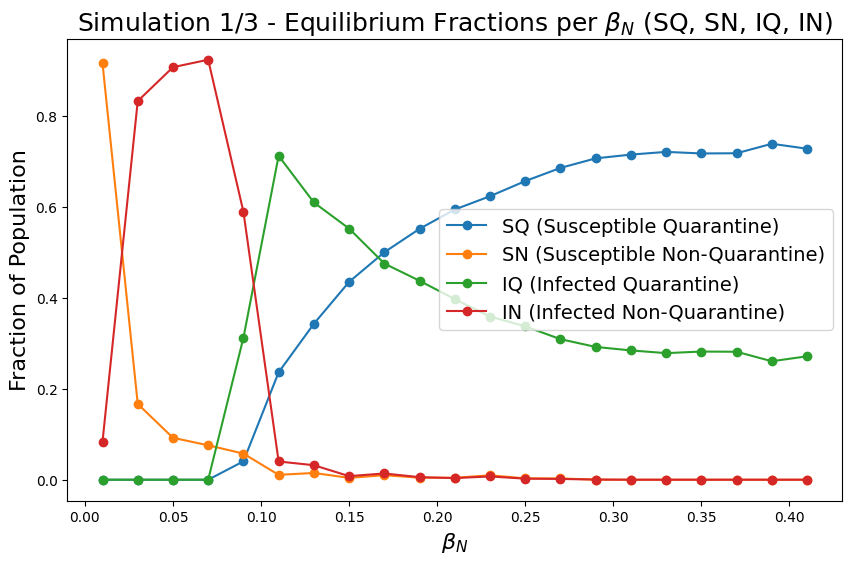

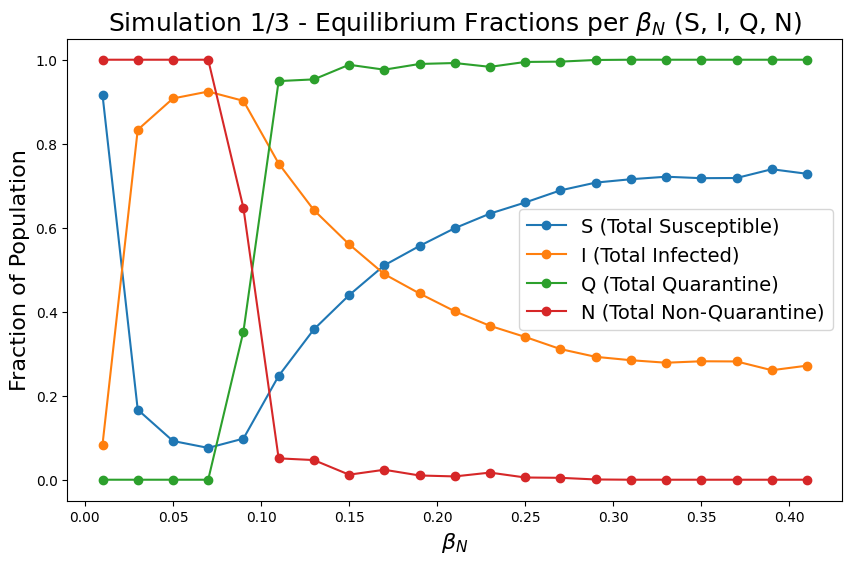

Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached


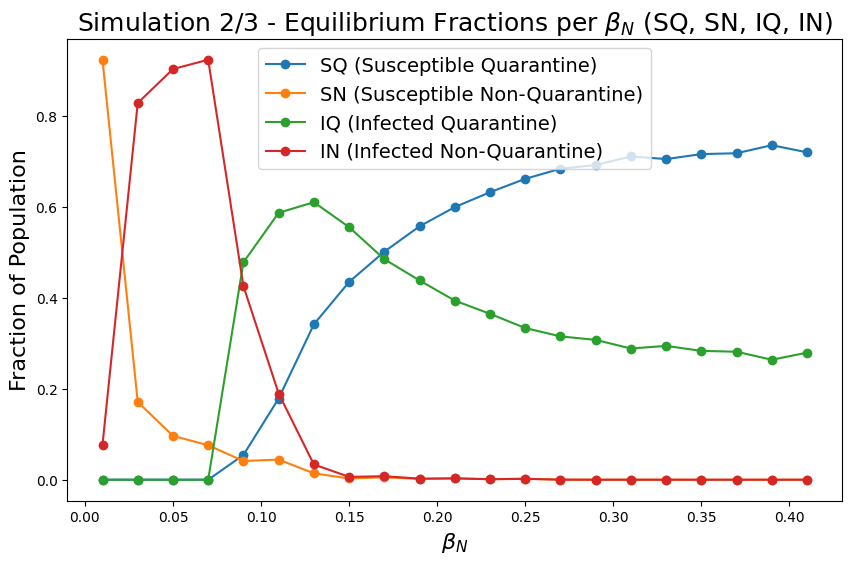

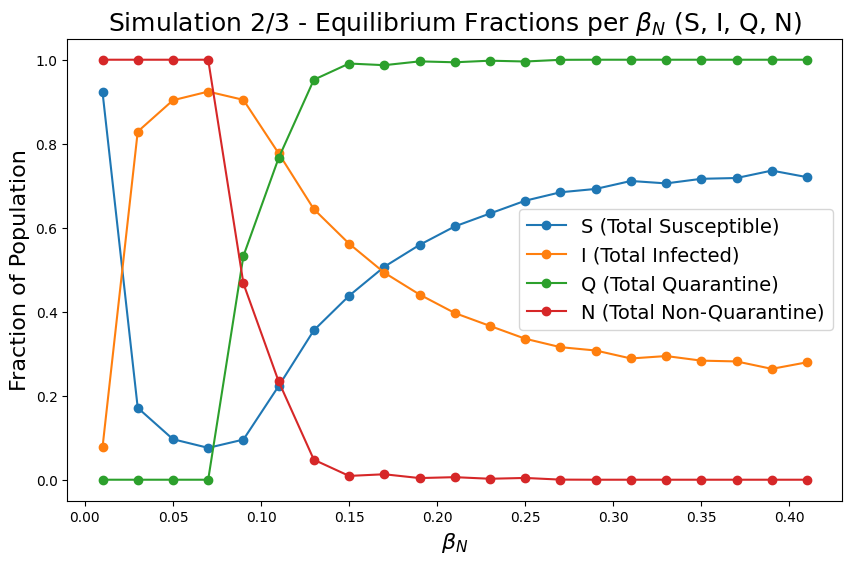

Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached


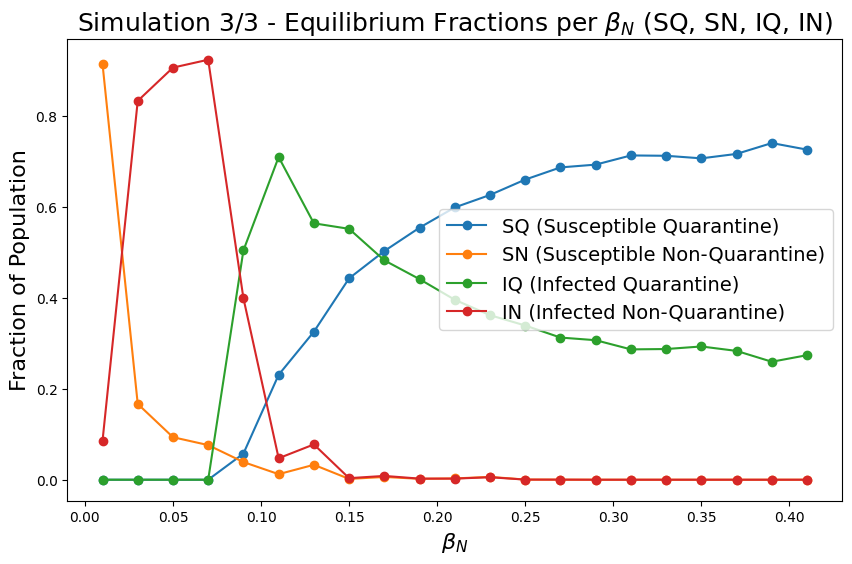

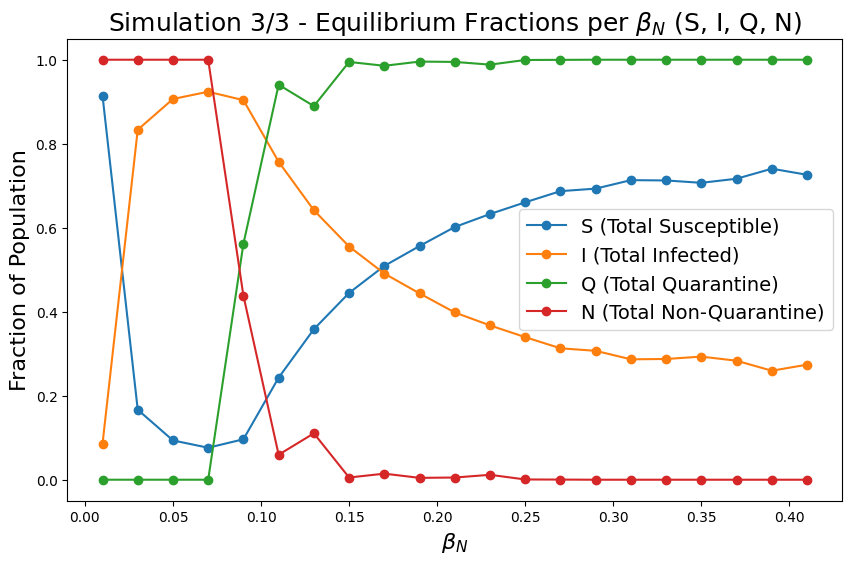

<ipython-input-3-009cf61f9e46>:118: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61f9e46>:119: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61f9e46>:120: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61

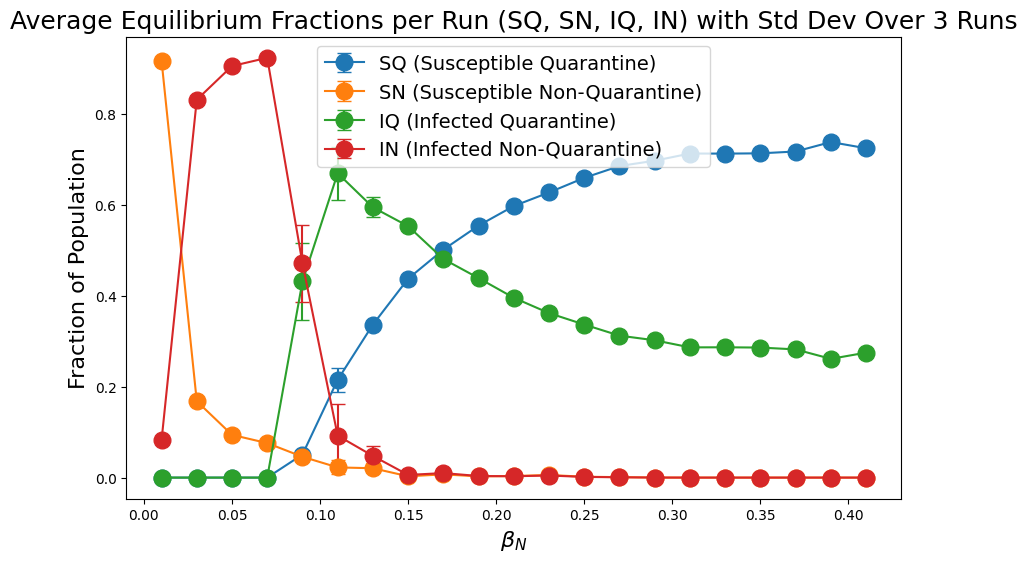

<ipython-input-3-009cf61f9e46>:141: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_S, yerr=std_S, label='S (Total Susceptible)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61f9e46>:142: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_I, yerr=std_I, label='I (Total Infected)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61f9e46>:143: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_Q, yerr=std_Q, label='Q (Total Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-3-009cf61f9e46>:144: UserWarning: mark

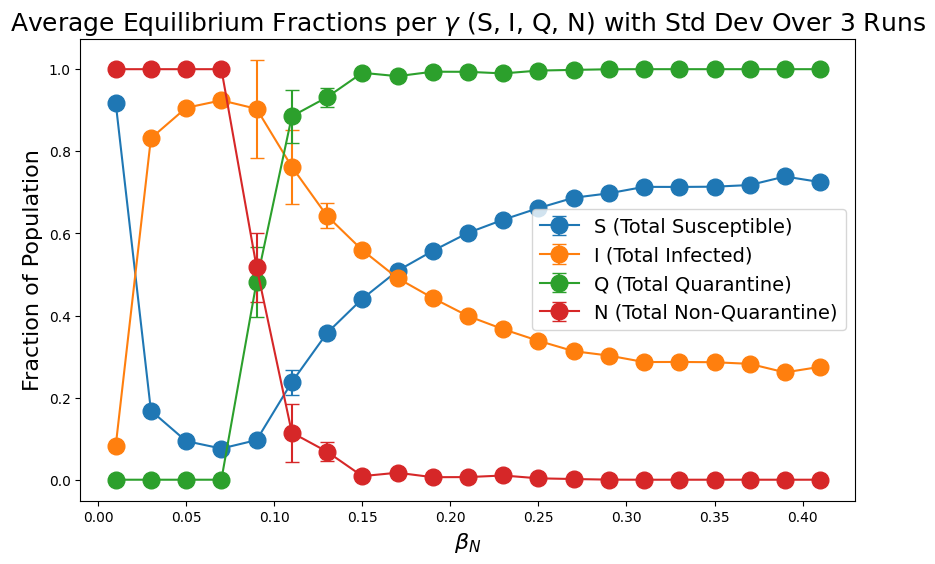

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to run the simulation and collect data per `BN` value for each simulation
def simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst, num_runs, interval=None, interval_runs=None):
    # Arrays to store individual and cumulative results
    all_results_SQ = np.zeros((len(BN_lst), num_runs))
    all_results_SN = np.zeros((len(BN_lst), num_runs))
    all_results_IQ = np.zeros((len(BN_lst), num_runs))
    all_results_IN = np.zeros((len(BN_lst), num_runs))

    for run in range(num_runs):
        results_SQ, results_SN, results_IQ, results_IN = [], [], [], []
        results_S, results_I, results_Q, results_N = [], [], [], []

        for i, BN in enumerate(BN_lst):
            # Define the number of runs for this interval
            if interval and interval[0] <= BN <= interval[1] and interval_runs:
                current_runs = interval_runs
            else:
                current_runs = num_runs

            # Run individual simulations to reach equilibrium
            individual_SQ, individual_SN, individual_IQ, individual_IN = [], [], [], []
            for _ in range(current_runs):
                BA = (BN + BQ) / 2
                draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
                individual_SQ.append(draw_log3[-1])
                individual_SN.append(draw_log4[-1])
                individual_IQ.append(draw_log5[-1])
                individual_IN.append(draw_log6[-1])

            # Store mean values for this `BN` across runs
            results_SQ.append(np.mean(individual_SQ))
            results_SN.append(np.mean(individual_SN))
            results_IQ.append(np.mean(individual_IQ))
            results_IN.append(np.mean(individual_IN))

            # Calculate S, I, Q, N
            results_S.append(results_SQ[-1] + results_SN[-1])
            results_I.append(results_IQ[-1] + results_IN[-1])
            results_Q.append(results_SQ[-1] + results_IQ[-1])
            results_N.append(results_SN[-1] + results_IN[-1])

            # Accumulate all results for calculating overall statistics
            all_results_SQ[i, run] = results_SQ[-1]
            all_results_SN[i, run] = results_SN[-1]
            all_results_IQ[i, run] = results_IQ[-1]
            all_results_IN[i, run] = results_IN[-1]

        # Plot this simulation's results (SQ, SN, IQ, IN)
        plt.figure(figsize=(10, 6))
        plt.plot(BN_lst, results_SQ, label='SQ (Susceptible Quarantine)', marker='o')
        plt.plot(BN_lst, results_SN, label='SN (Susceptible Non-Quarantine)', marker='o')
        plt.plot(BN_lst, results_IQ, label='IQ (Infected Quarantine)', marker='o')
        plt.plot(BN_lst, results_IN, label='IN (Infected Non-Quarantine)', marker='o')
        plt.xlabel(r'$\beta_N$', fontsize=16)
        plt.ylabel('Fraction of Population', fontsize=16)
        plt.title(rf"Simulation {run+1}/{num_runs} - Equilibrium Fractions per $\beta_N$ (SQ, SN, IQ, IN)", fontsize=18)
        plt.legend(prop={'size': 14})
        # Grid lines removed
        plt.show()

        # Plot this simulation's results (S, I, Q, N)
        plt.figure(figsize=(10, 6))
        plt.plot(BN_lst, results_S, label='S (Total Susceptible)', marker='o')
        plt.plot(BN_lst, results_I, label='I (Total Infected)', marker='o')
        plt.plot(BN_lst, results_Q, label='Q (Total Quarantine)', marker='o')
        plt.plot(BN_lst, results_N, label='N (Total Non-Quarantine)', marker='o')
        plt.xlabel(r'$\beta_N$', fontsize=16)
        plt.ylabel('Fraction of Population', fontsize=16)
        plt.title(rf"Simulation {run+1}/{num_runs} - Equilibrium Fractions per $\beta_N$ (S, I, Q, N)", fontsize=18)
        plt.legend(prop={'size': 14})
        # Grid lines removed
        plt.show()

    return all_results_SQ, all_results_SN, all_results_IQ, all_results_IN

# Simulate dynamics for a single BN value
def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time):
    # simulate_dynamics should be defined elsewhere in your code.
    _, _, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
    return draw_log3, draw_log4, draw_log5, draw_log6

# Set up parameters and run simulations
BN_lst = np.arange(0.01, 0.411, 0.02)  # Vary BN from 0.01 to 0.41
rec = 0.02
delta = 25
omega = 20
BQ = 0.01
tau = 0.5
time = 500
size = 10000
num_runs = 3
interval = (0.05, 0.15)
interval_runs = 3

# generate_random_array, modify_array, and form_links should be defined elsewhere in your code.
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(100, 100)

all_results_SQ, all_results_SN, all_results_IQ, all_results_IN = simulate_single_parameter(
    k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst, num_runs, interval, interval_runs)

# Calculate average and standard deviation across all simulations
avg_SQ = np.mean(all_results_SQ, axis=1)
avg_SN = np.mean(all_results_SN, axis=1)
avg_IQ = np.mean(all_results_IQ, axis=1)
avg_IN = np.mean(all_results_IN, axis=1)
std_SQ = np.std(all_results_SQ, axis=1)
std_SN = np.std(all_results_SN, axis=1)
std_IQ = np.std(all_results_IQ, axis=1)
std_IN = np.std(all_results_IN, axis=1)

# Final plot with average values and error bars for SQ, SN, IQ, IN
plt.figure(figsize=(10, 6))
plt.errorbar(BN_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.xlabel(r'$\beta_N$', fontsize=16)
plt.ylabel('Fraction of Population', fontsize=16)
plt.title(rf"Average Equilibrium Fractions per Run (SQ, SN, IQ, IN) with Std Dev Over {num_runs} Runs", fontsize=18)
plt.legend(prop={'size': 14})
# Grid lines removed
plt.show()

# Calculate S, I, Q, N averages
avg_S = avg_SQ + avg_SN
avg_I = avg_IQ + avg_IN
avg_Q = avg_SQ + avg_IQ
avg_N = avg_SN + avg_IN
std_S = np.sqrt(std_SQ**2 + std_SN**2)
std_I = np.sqrt(std_IQ**2 + std_IN**2)
std_Q = np.sqrt(std_SQ**2 + std_IQ**2)
std_N = np.sqrt(std_SN**2 + std_IN**2)

# Final plot with average values and error bars (S, I, Q, N)
plt.figure(figsize=(10, 6))
plt.errorbar(BN_lst, avg_S, yerr=std_S, label='S (Total Susceptible)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_I, yerr=std_I, label='I (Total Infected)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_Q, yerr=std_Q, label='Q (Total Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_N, yerr=std_N, label='N (Total Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.xlabel(r'$\beta_N$', fontsize=16)
plt.ylabel('Fraction of Population', fontsize=16)
plt.title(rf"Average Equilibrium Fractions per $\gamma$ (S, I, Q, N) with Std Dev Over {num_runs} Runs", fontsize=18)
plt.legend(prop={'size': 14})
# Grid lines removed
plt.show()


<ipython-input-4-8ef9277702f7>:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>

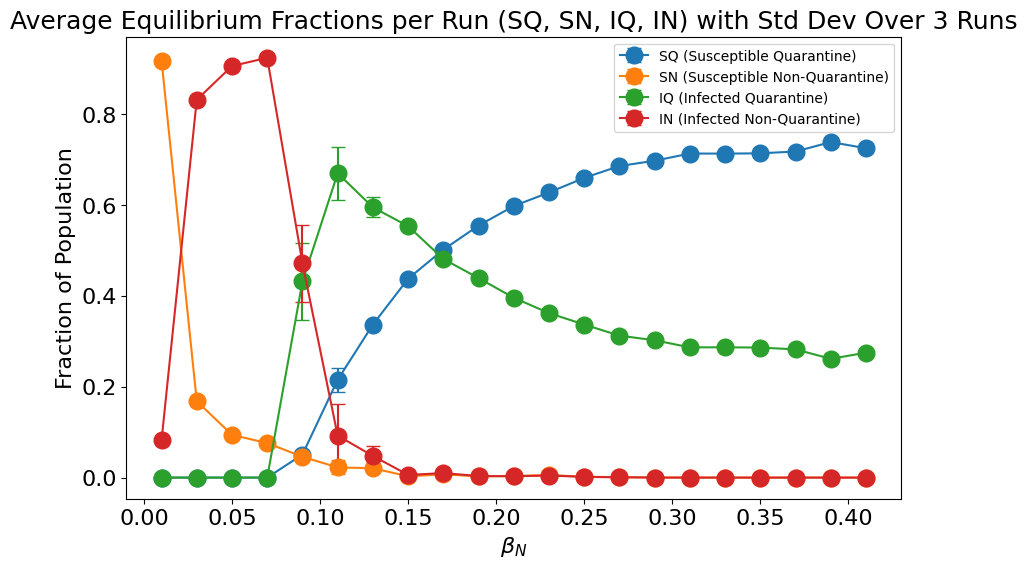

<ipython-input-4-8ef9277702f7>:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_S, yerr=std_S, label='S (Total Susceptible)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_I, yerr=std_I, label='I (Total Infected)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>:19: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(BN_lst, avg_Q, yerr=std_Q, label='Q (Total Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-4-8ef9277702f7>:20: UserWarning: marker i

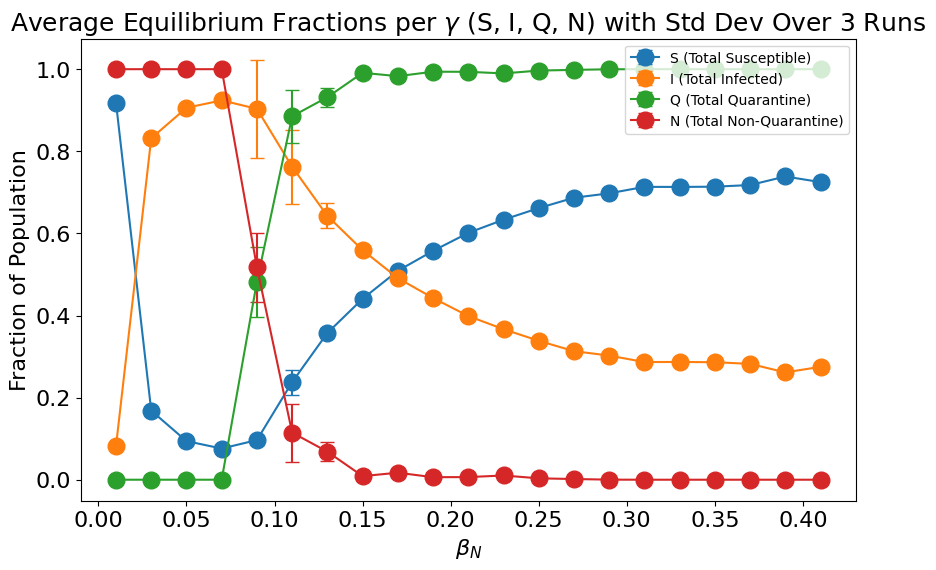

In [ ]:
# Final plot with average values and error bars for SQ, SN, IQ, IN
plt.figure(figsize=(10, 6))
plt.errorbar(BN_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.xlabel(r'$\beta_N$', fontsize=16)
plt.ylabel('Fraction of Population', fontsize=16)
plt.title(rf"Average Equilibrium Fractions per Run (SQ, SN, IQ, IN) with Std Dev Over {num_runs} Runs", fontsize=18)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(loc='upper right', prop={'size': 18})
plt.show()

# Final plot with average values and error bars for S, I, Q, N
plt.figure(figsize=(10, 6))
plt.errorbar(BN_lst, avg_S, yerr=std_S, label='S (Total Susceptible)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_I, yerr=std_I, label='I (Total Infected)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_Q, yerr=std_Q, label='Q (Total Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(BN_lst, avg_N, yerr=std_N, label='N (Total Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.xlabel(r'$\beta_N$', fontsize=16)
plt.ylabel('Fraction of Population', fontsize=16)
plt.title(rf"Average Equilibrium Fractions per $\gamma$ (S, I, Q, N) with Std Dev Over {num_runs} Runs", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper right', prop={'size': 10})
plt.show()


Gamma (rec)

[debug] received δ=30, k0 counts: [4950 4950   50   50]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0

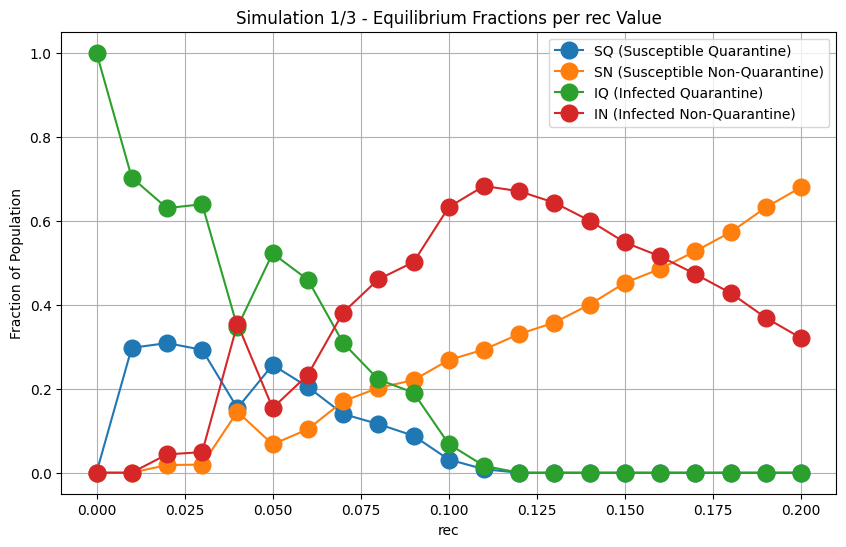

[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 

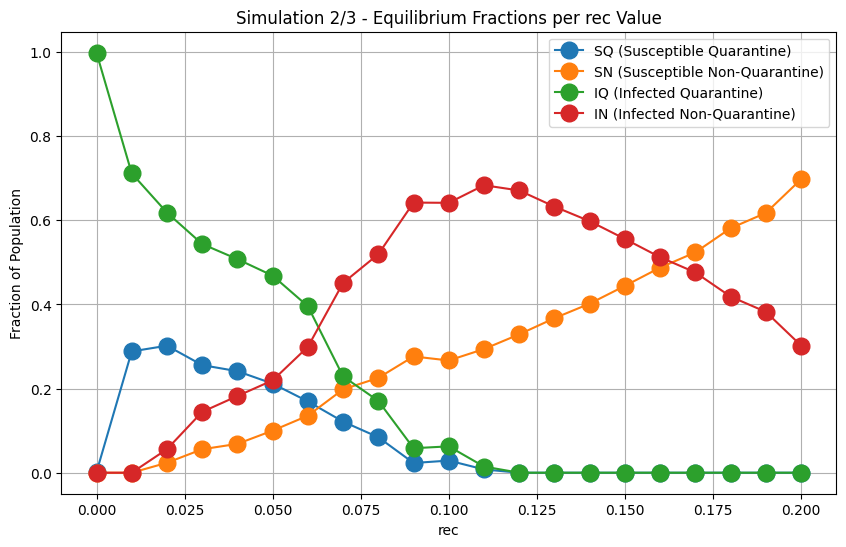

[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] received δ=30, k0 counts: [   0 9900    0  100]
Equil. Reached
[debug] re

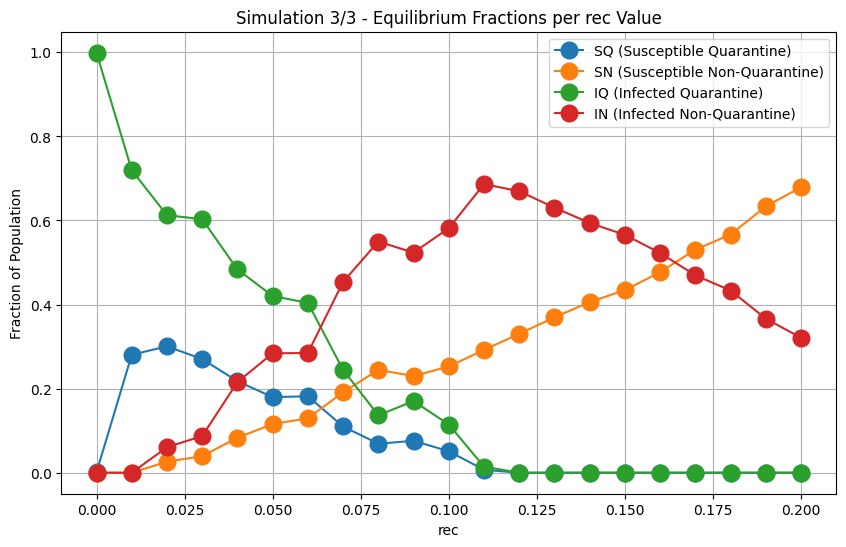

/tmp/ipython-input-18-330647726.py:109: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ,
/tmp/ipython-input-18-330647726.py:113: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_SN, yerr=std_SN,
/tmp/ipython-input-18-330647726.py:117: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ,
/tmp/ipython-input-18-330647726.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-D" (-> marker='D'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_IN, yerr=std_IN,


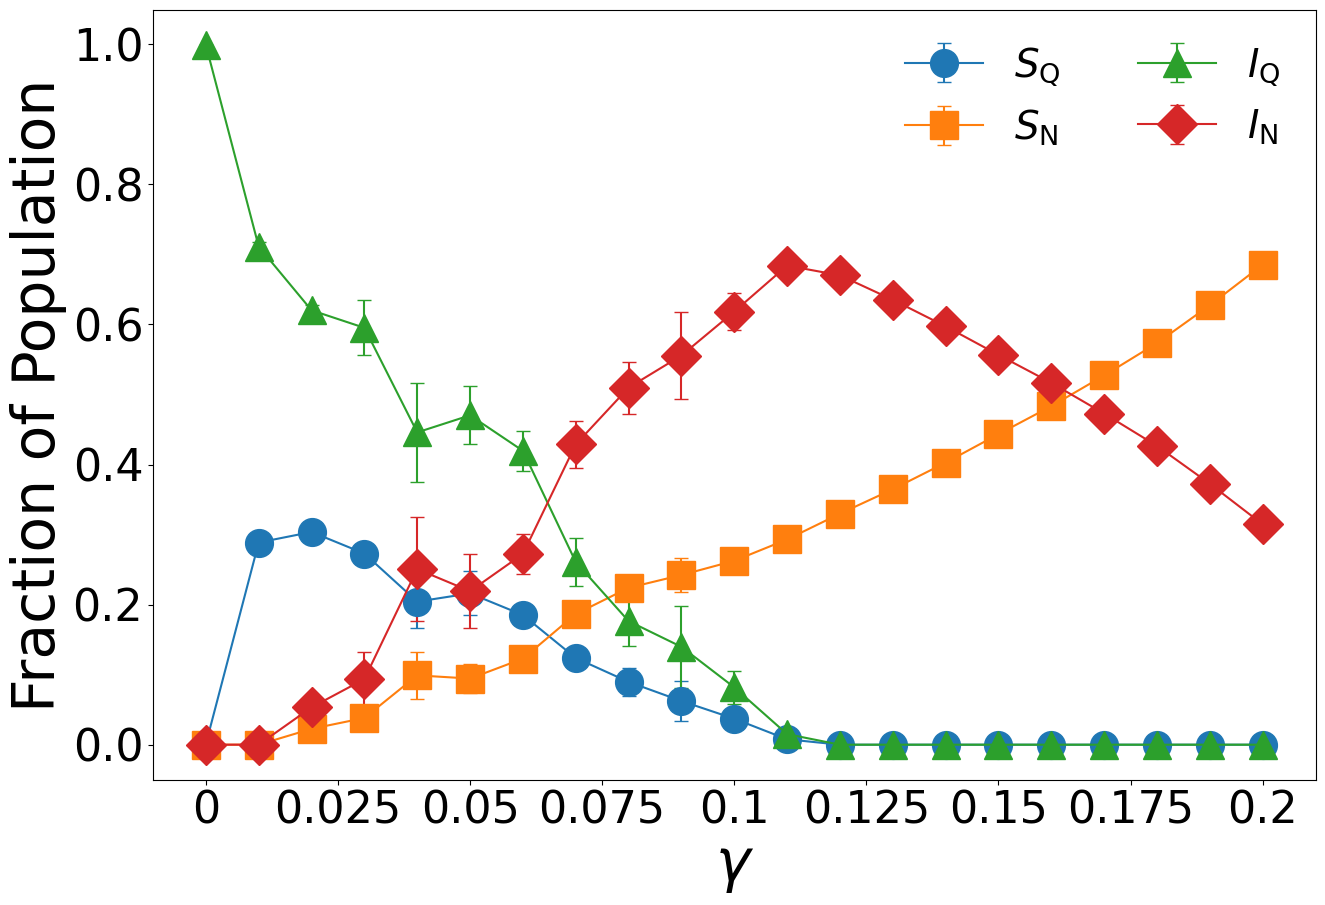

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to run the simulation and collect data per `rec` value for each simulation
def simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, BN, time, rec_lst, num_runs, interval=None, interval_runs=None):
    # Arrays to store individual and cumulative results
    all_results_SQ = np.zeros((len(rec_lst), num_runs))
    all_results_SN = np.zeros((len(rec_lst), num_runs))
    all_results_IQ = np.zeros((len(rec_lst), num_runs))
    all_results_IN = np.zeros((len(rec_lst), num_runs))

    for run in range(num_runs):
        results_SQ, results_SN, results_IQ, results_IN = [], [], [], []

        for i, rec in enumerate(rec_lst):
            # Define the number of runs for this interval
            if interval and interval[0] <= rec <= interval[1] and interval_runs:
                current_runs = interval_runs
            else:
                current_runs = num_runs

            # Run individual simulations to reach equilibrium
            individual_SQ, individual_SN, individual_IQ, individual_IN = [], [], [], []
            for _ in range(current_runs):
                BA = (BN + BQ) / 2
                draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
                individual_SQ.append(draw_log3[-1])
                individual_SN.append(draw_log4[-1])
                individual_IQ.append(draw_log5[-1])
                individual_IN.append(draw_log6[-1])

            # Store mean values for this `rec` across runs
            results_SQ.append(np.mean(individual_SQ))
            results_SN.append(np.mean(individual_SN))
            results_IQ.append(np.mean(individual_IQ))
            results_IN.append(np.mean(individual_IN))

            # Accumulate all results for calculating overall statistics
            all_results_SQ[i, run] = np.mean(individual_SQ)
            all_results_SN[i, run] = np.mean(individual_SN)
            all_results_IQ[i, run] = np.mean(individual_IQ)
            all_results_IN[i, run] = np.mean(individual_IN)

        # Plot this simulation's results
        plt.figure(figsize=(10, 6))
        plt.plot(rec_lst, results_SQ, label='SQ (Susceptible Quarantine)', marker='o', markersize=12)
        plt.plot(rec_lst, results_SN, label='SN (Susceptible Non-Quarantine)', marker='o', markersize=12)
        plt.plot(rec_lst, results_IQ, label='IQ (Infected Quarantine)', marker='o', markersize=12)
        plt.plot(rec_lst, results_IN, label='IN (Infected Non-Quarantine)', marker='o', markersize=12)
        plt.xlabel('rec')
        plt.ylabel('Fraction of Population')
        plt.title(f'Simulation {run+1}/{num_runs} - Equilibrium Fractions per rec Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    return all_results_SQ, all_results_SN, all_results_IQ, all_results_IN

# Simulate dynamics for a single BN value
def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time):
    _, _, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
    return draw_log3, draw_log4, draw_log5, draw_log6

# Set up parameters and run simulations
BN = 0.09
rec_lst = np.arange(0, 0.201, 0.01)#0.005
delta = 30
omega = 17.5
BQ = 0.01
tau = 1 #0.5   <-----------------------2025/6/14 change
time = 500
size = 10000#40000
num_runs = 3
interval = (0.02, 0.125)
interval_runs = 12#10#8#3
#Required Time 178sims*20sec ~ 1hr
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(100, 100)

all_results_SQ, all_results_SN, all_results_IQ, all_results_IN = simulate_single_parameter(
    k_lst, links, omega, delta, BQ, tau, BN, time, rec_lst, num_runs, interval, interval_runs)

# Calculate average and standard deviation across all simulations
avg_SQ = np.mean(all_results_SQ, axis=1)
avg_SN = np.mean(all_results_SN, axis=1)
avg_IQ = np.mean(all_results_IQ, axis=1)
avg_IN = np.mean(all_results_IN, axis=1)
std_SQ = np.std(all_results_SQ, axis=1)
std_SN = np.std(all_results_SN, axis=1)
std_IQ = np.std(all_results_IQ, axis=1)
std_IN = np.std(all_results_IN, axis=1)

# Final plot with average values and error bars for γ (rec) simulation
# plt.figure(figsize=(10, 6))
# plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
# plt.errorbar(rec_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
# plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
# plt.errorbar(rec_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)

#--------6/14-----------------
# Final plot with average values and error bars for γ (rec) simulation
plt.figure(figsize=(15, 10))
# plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
# plt.errorbar(rec_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-s', capsize=5, marker='s', markersize=12)
# plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-^', capsize=5, marker='^', markersize=12)
# plt.errorbar(rec_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-D', capsize=5, marker='D', markersize=12)

plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ,
             label=r'$S_{\mathrm{Q}}$',
             fmt='-o', capsize=5, marker='o', markersize=20)

plt.errorbar(rec_lst, avg_SN, yerr=std_SN,
             label=r'$S_{\mathrm{N}}$',
             fmt='-s', capsize=5, marker='s', markersize=20)

plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ,
             label=r'$I_{\mathrm{Q}}$',
             fmt='-^', capsize=5, marker='^', markersize=20)

plt.errorbar(rec_lst, avg_IN, yerr=std_IN,
             label=r'$I_{\mathrm{N}}$',
             fmt='-D', capsize=5, marker='D', markersize=20)

# --- legend: two columns → two rows ---------------------------------
plt.legend(ncol=2, frameon=False, loc='upper right', prop={'size': 28})   # <- SQ SN on row-1,
                                                        #    IQ IN on row-2

plt.xlabel(r'$\gamma$', fontsize=42)#16
plt.ylabel('Fraction of Population', fontsize=42)#28
# plt.title(rf'Average Equilibrium Fractions per $\gamma$ (SQ, SN, IQ, IN) with Std Dev Over {num_runs} Runs', fontsize=18)
#plt.xticks(fontsize=32)

# xticks = rec_lst
# xtick_labels = [str(round(x, 2)).rstrip('0').rstrip('.') if x != 0 else '0' for x in xticks]
# plt.xticks(ticks=xticks, labels=xtick_labels, fontsize=32)

import matplotlib.ticker as ticker

# … after you’ve done your plotting …
ax = plt.gca()

# Formatter: format with two decimals, then rstrip any trailing zeros and a trailing dot
formatter = ticker.FuncFormatter(
    lambda x, pos: '{:.3f}'.format(x).rstrip('0').rstrip('.')
)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='y', labelsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
#plt.legend(loc='upper right', prop={'size': 23})

# Set custom ticks and format them to remove trailing zeros
# Keep original ticks but format labels nicely
# Set clean tick labels while keeping all values in rec_lst



plt.show()


<ipython-input-9-1780490928>:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
<ipython-input-9-1780490928>:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-s', capsize=5, marker='s', markersize=12)
<ipython-input-9-1780490928>:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-^', capsize=5, marker='^', markersize=12)
<ipython-input-9-1780490928>:7: U

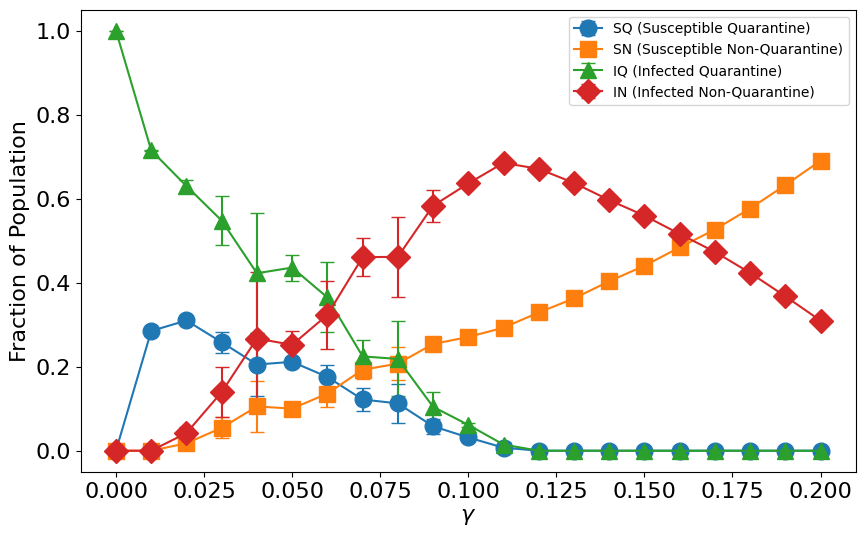

In [ ]:
#--------6/14-----------------
# Final plot with average values and error bars for γ (rec) simulation
plt.figure(figsize=(10, 6))
plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
plt.errorbar(rec_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-s', capsize=5, marker='s', markersize=12)
plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-^', capsize=5, marker='^', markersize=12)
plt.errorbar(rec_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-D', capsize=5, marker='D', markersize=12)


plt.xlabel(r'$\gamma$', fontsize=28)#16
plt.ylabel('Fraction of Population', fontsize=28)
# plt.title(rf'Average Equilibrium Fractions per $\gamma$ (SQ, SN, IQ, IN) with Std Dev Over {num_runs} Runs', fontsize=18)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.legend(loc='upper right', prop={'size': 18})
plt.show()

# Fig 4. Omega/Delta

omega line graph testing

Running simulations by varying Omega...

  Run 1/3
[debug] received δ=5, k0 counts: [4950 4950   50   50]
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=5, k0 counts: [4950 4950   50   50]

/tmp/ipython-input-16-1135840283.py:118: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
/tmp/ipython-input-16-1135840283.py:121: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SN, yerr=std_SN,
/tmp/ipython-input-16-1135840283.py:124: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
/tmp/ipython-input-16-1135840283.py:127: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IN, yerr=std_IN,


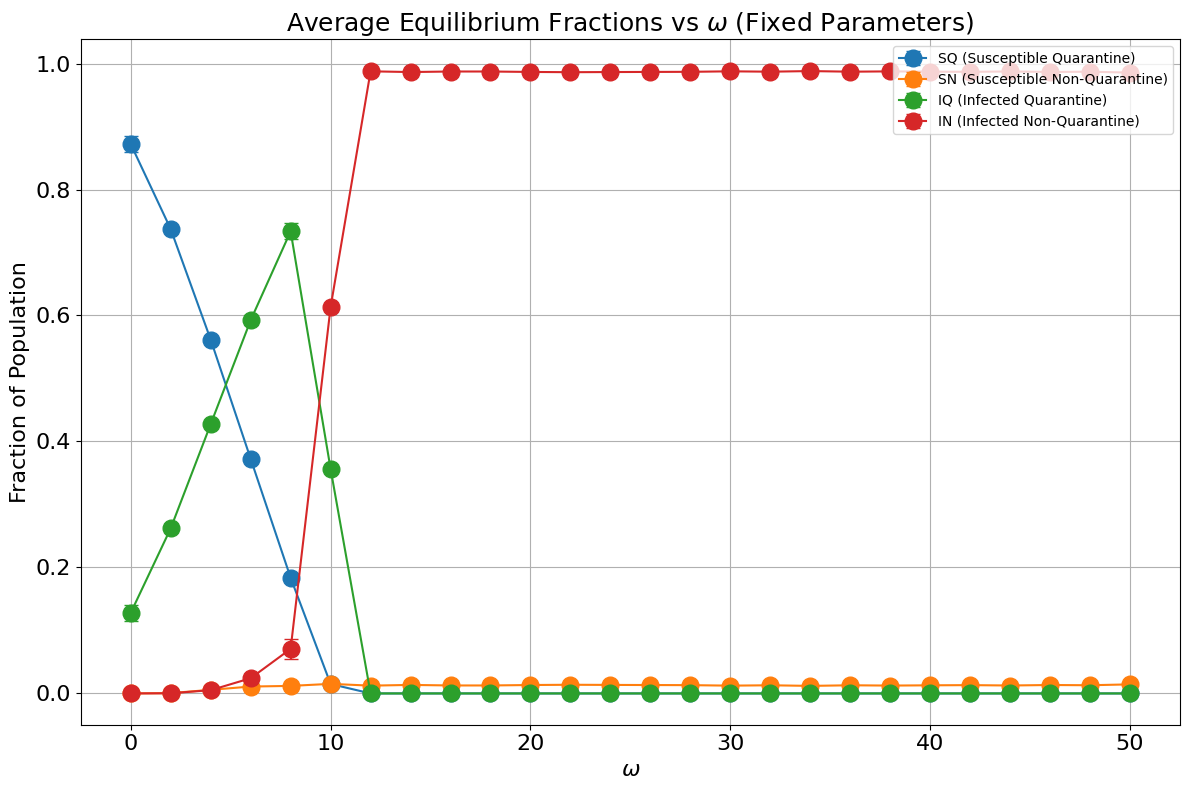

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def generate_random_array(size):
    half_size = size // 2
    indices = np.random.choice(size, half_size, replace=False)
    array = np.zeros(size, dtype=int)
    array[indices] = 1
    np.random.shuffle(array)
    return array

def modify_array(arr):
    N = len(arr)
    num_twos = int(N * 0.005)
    num_threes = int(N * 0.005)

    zero_indices = np.where(arr == 0)[0]
    one_indices = np.where(arr == 1)[0]

    selected_zero_indices = np.random.choice(zero_indices, num_twos, replace=False)
    selected_one_indices = np.random.choice(one_indices, num_threes, replace=False)

    arr[selected_zero_indices] = 2
    arr[selected_one_indices] = 3

    return arr

def form_links(x, y):
    links = []
    for i in range(x):
        for k in range(y - 1):
            links.append([i * y + k, i * y + k + 1])
    for i in range(y):
        for k in range(x - 1):
            links.append([i + (k) * y, i + (k + 1) * y])
    for i in range(x):
        links.append([i * y, i * y + y - 1])
    for i in range(y):
        links.append([i, (x - 1) * y + i])
    return links

def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time, seed=None):
    """
    Runs a single simulation and returns the equilibrium fractions.

    Parameters:
    - k_lst: Initial state array
    - links: Network links
    - omega, delta, BN, BQ, BA, tau, rec, time: Simulation parameters
    - seed: Random seed for reproducibility

    Returns:
    - draw_log3: Fraction of Sq (Susceptible Quarantine)
    - draw_log4: Fraction of Sn (Susceptible Non-Quarantine)
    - draw_log5: Fraction of Iq (Infected Quarantine)
    - draw_log6: Fraction of In (Infected Non-Quarantine)
    """
    draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(
        k_lst.copy(), links, omega, delta, BN, BQ, BA, tau, rec, time#, seed=seed (k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
    )
    return draw_log3, draw_log4, draw_log5, draw_log6

def simulate_varying_parameter(k_lst, links, fixed_params, varying_param_name, varying_param_list, BQ, tau, time, num_runs):# rec,
    """
    Simulates the dynamics by varying one parameter (omega or delta).

    Parameters:
    - k_lst: Initial state array
    - links: Network links
    - fixed_params: Dictionary of fixed parameters
    - varying_param_name: Name of the parameter to vary ('omega' or 'delta')
    - varying_param_list: List of values for the varying parameter
    - BQ, tau, rec, time: Other simulation parameters
    - num_runs: Number of simulation runs per parameter value

    Returns:
    - all_results_SQ, all_results_SN, all_results_IQ, all_results_IN: Arrays of results
    """
    param_values = varying_param_list
    num_params = len(param_values)

    # Arrays to store results
    all_results_SQ = np.zeros((num_params, num_runs))
    all_results_SN = np.zeros((num_params, num_runs))
    all_results_IQ = np.zeros((num_params, num_runs))
    all_results_IN = np.zeros((num_params, num_runs))

    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")
        for i, param_value in enumerate(param_values):
            # Update the varying parameter
            current_params = fixed_params.copy()
            current_params[varying_param_name] = param_value

            omega = current_params.get('omega', None)
            delta = current_params.get('delta', None)
            BN = current_params.get('BN', None)
            rec = current_params.get('rec', None)

            BA = (BN + BQ) / 2   #<----------------------------------------------------------BA definition is different across tests

            # Run the simulation with the current parameters
            draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(
                k_lst.copy(), links, omega, delta, BN, BQ, BA, tau, rec, time, seed=run + 1
            )

            # Store the equilibrium fractions
            all_results_SQ[i, run] = draw_log3[-1]
            all_results_SN[i, run] = draw_log4[-1]
            all_results_IQ[i, run] = draw_log5[-1]
            all_results_IN[i, run] = draw_log6[-1]

    return all_results_SQ, all_results_SN, all_results_IQ, all_results_IN
def plot_varying_parameter(param_list, avg_SQ, avg_SN, avg_IQ, avg_IN,
                           std_SQ, std_SN, std_IQ, std_IN, varying_param_name, fixed_param_value):
    plt.figure(figsize=(12, 8))

    # Plot each equilibrium fraction with error bars
    plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
                 label='SQ (Susceptible Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_SN, yerr=std_SN,
                 label='SN (Susceptible Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
                 label='IQ (Infected Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IN, yerr=std_IN,
                 label='IN (Infected Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)

    # For omega, use the Greek symbol on the x-axis
    if varying_param_name.lower() == 'omega':
        xlabel = r'$\omega$'
    else:
        xlabel = varying_param_name.capitalize()

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Fraction of Population', fontsize=16)
    plt.title(rf'Average Equilibrium Fractions vs {xlabel} (Fixed Parameters)', fontsize=18)

    # Increase tick label sizes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Place the legend in the upper right corner with smaller text
    plt.legend(loc='upper right', prop={'size': 10})
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Fixed parameters (excluding the varying one)
fixed_params_omega = {
    'omega': None,  # To be varied
    'delta': 5,     # Fixed delta
    'BN': 0.21,       # Fixed BN (BetaN)
    'rec': 0.02
}

fixed_params_delta = {
    'omega': 22.5,     # Fixed omega
    'delta': None,   # To be varied
    'BN': 0.41,       # Fixed BN (BetaN)
    'rec': 0.04
}

# Define the varying parameter lists
omega_list = np.arange(0, 50.5, 2)#1  # Example: Vary omega from 0 to 50 in steps of 2.5
delta_list = np.arange(0, 25.01, 1)#0.5     # Example: Vary delta from 0 to 50 in steps of 5

# Other fixed simulation parameters
BQ = 0.01
tau = 1 #0.5   <-----------------------2025/6/14 change
#rec = 0.02
time = 500
size = 10000
num_runs = 3

# Generate the initial state array and network links
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(100, 100)  # Adjust x and y based on your network size
print("Running simulations by varying Omega...\n")

# Update the fixed_params_omega dictionary to indicate 'omega' is to be varied
varying_param_name = 'omega'
varying_param_list = omega_list

# Run the simulations
all_results_SQ_omega, all_results_SN_omega, all_results_IQ_omega, all_results_IN_omega = simulate_varying_parameter(
    k_lst, links, fixed_params_omega, varying_param_name, varying_param_list, BQ, tau, time, num_runs#rec,
)

# Calculate averages and standard deviations
avg_SQ_omega = np.mean(all_results_SQ_omega, axis=1)
avg_SN_omega = np.mean(all_results_SN_omega, axis=1)
avg_IQ_omega = np.mean(all_results_IQ_omega, axis=1)
avg_IN_omega = np.mean(all_results_IN_omega, axis=1)

std_SQ_omega = np.std(all_results_SQ_omega, axis=1)
std_SN_omega = np.std(all_results_SN_omega, axis=1)
std_IQ_omega = np.std(all_results_IQ_omega, axis=1)
std_IN_omega = np.std(all_results_IN_omega, axis=1)

# Plot the results
plot_varying_parameter(
    varying_param_list, avg_SQ_omega, avg_SN_omega, avg_IQ_omega, avg_IN_omega,
    std_SQ_omega, std_SN_omega, std_IQ_omega, std_IN_omega,
    varying_param_name, fixed_param_value=fixed_params_omega['delta']
)

/tmp/ipython-input-17-1996072593.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
/tmp/ipython-input-17-1996072593.py:61: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-s" (-> marker='s'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SN, yerr=std_SN,
/tmp/ipython-input-17-1996072593.py:65: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-^" (-> marker='^'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
/tmp/ipython-input-17-1996072593.py:69: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-D" (-> marker='D'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IN, yerr=std_IN,


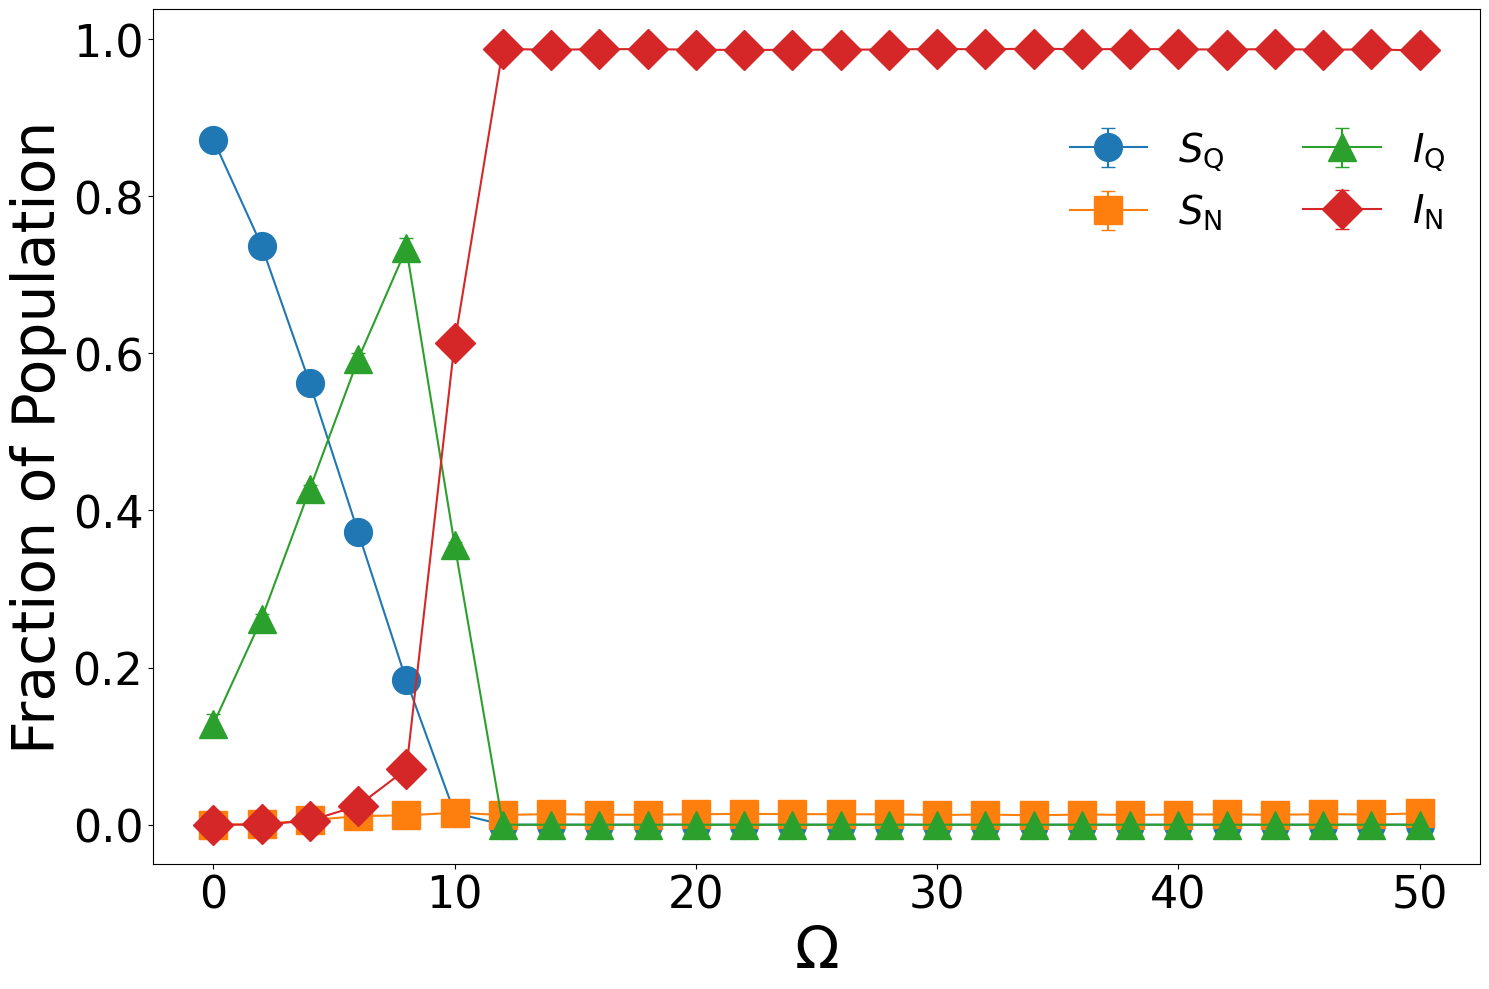

In [ ]:
def plot_varying_parameter(param_list, avg_SQ, avg_SN, avg_IQ, avg_IN,
                           std_SQ, std_SN, std_IQ, std_IN, varying_param_name, fixed_param_value):
    # plt.figure(figsize=(12, 8))

    # # Plot each equilibrium fraction with error bars
    # plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
    #              label='SQ (Susceptible Quarantine)', fmt='-o', marker='o',
    #              capsize=5, markersize=12)
    # plt.errorbar(param_list, avg_SN, yerr=std_SN,
    #              label='SN (Susceptible Non-Quarantine)', fmt='-o', marker='o',
    #              capsize=5, markersize=12)
    # plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
    #              label='IQ (Infected Quarantine)', fmt='-o', marker='o',
    #              capsize=5, markersize=12)
    # plt.errorbar(param_list, avg_IN, yerr=std_IN,
    #              label='IN (Infected Non-Quarantine)', fmt='-o', marker='o',
    #              capsize=5, markersize=12)

    # #------------6/14 change---------------------

    # # Final plot with average values and error bars for γ (rec) simulation
    # #plt.figure(figsize=(10, 6))
    # plt.figure(figsize=(12, 8))
    # plt.errorbar(param_list, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
    # plt.errorbar(param_list, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-s', capsize=5, marker='s', markersize=12)
    # plt.errorbar(param_list, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-^', capsize=5, marker='^', markersize=12)
    # plt.errorbar(param_list, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-D', capsize=5, marker='D', markersize=12)

    # # Use uppercase Omega for the x-axis label if varying parameter is omega
    # if varying_param_name.lower() == 'omega':
    #     xlabel = r'$\Omega$'
    # else:
    #     xlabel = varying_param_name.capitalize()

    # plt.xlabel(xlabel, fontsize=24)#16
    # plt.ylabel('Fraction of Population', fontsize=24)#16
    # #plt.title(rf'Average Equilibrium Fractions vs {xlabel} (Fixed Parameters)', fontsize=18)

    # # Increase tick label sizes
    # plt.xticks(fontsize=24)#16
    # plt.yticks(fontsize=24)#16

    # # Move the legend a bit down in the upper right corner
    # plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), prop={'size': 16})
    # #plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    #--------6/16-----------------
    # Final plot with average values and error bars for γ (rec) simulation
    plt.figure(figsize=(15, 10))
    # plt.errorbar(rec_lst, avg_SQ, yerr=std_SQ, label='SQ (Susceptible Quarantine)', fmt='-o', capsize=5, marker='o', markersize=12)
    # plt.errorbar(rec_lst, avg_SN, yerr=std_SN, label='SN (Susceptible Non-Quarantine)', fmt='-s', capsize=5, marker='s', markersize=12)
    # plt.errorbar(rec_lst, avg_IQ, yerr=std_IQ, label='IQ (Infected Quarantine)', fmt='-^', capsize=5, marker='^', markersize=12)
    # plt.errorbar(rec_lst, avg_IN, yerr=std_IN, label='IN (Infected Non-Quarantine)', fmt='-D', capsize=5, marker='D', markersize=12)

    plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
                label=r'$S_{\mathrm{Q}}$',
                fmt='-o', capsize=5, marker='o', markersize=20)

    plt.errorbar(param_list, avg_SN, yerr=std_SN,
                label=r'$S_{\mathrm{N}}$',
                fmt='-s', capsize=5, marker='s', markersize=20)

    plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
                label=r'$I_{\mathrm{Q}}$',
                fmt='-^', capsize=5, marker='^', markersize=20)

    plt.errorbar(param_list, avg_IN, yerr=std_IN,
                label=r'$I_{\mathrm{N}}$',
                fmt='-D', capsize=5, marker='D', markersize=20)

    plt.legend(
        ncol=2,               # two columns ⇒ two rows for 4 labels
        frameon=False,        # no border
        loc='upper right',    # anchor legend box on axes’ upper-right corner
        bbox_to_anchor=(1, 0.9),  # fine-tune position (x=1, y=0.9)
        prop={'size': 28}     # legend font size
    )

    plt.xlabel( r'$\Omega$', fontsize=42)#16
    plt.ylabel('Fraction of Population', fontsize=42)
    # plt.title(rf'Average Equilibrium Fractions per $\gamma$ (SQ, SN, IQ, IN) with Std Dev Over {num_runs} Runs', fontsize=18)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    #plt.legend(loc='upper right', prop={'size': 23})
    plt.tight_layout()
    plt.show()

plot_varying_parameter(
    varying_param_list, avg_SQ_omega, avg_SN_omega, avg_IQ_omega, avg_IN_omega,
    std_SQ_omega, std_SN_omega, std_IQ_omega, std_IN_omega,
    varying_param_name, fixed_param_value=fixed_params_omega['delta']
)

Delta Line graph


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def generate_random_array(size):
    half_size = size // 2
    indices = np.random.choice(size, half_size, replace=False)
    array = np.zeros(size, dtype=int)
    array[indices] = 1
    np.random.shuffle(array)
    return array

def modify_array(arr):
    N = len(arr)
    num_twos = int(N * 0.005)
    num_threes = int(N * 0.005)

    zero_indices = np.where(arr == 0)[0]
    one_indices = np.where(arr == 1)[0]

    selected_zero_indices = np.random.choice(zero_indices, num_twos, replace=False)
    selected_one_indices = np.random.choice(one_indices, num_threes, replace=False)

    arr[selected_zero_indices] = 2
    arr[selected_one_indices] = 3

    return arr

def form_links(x, y):
    links = []
    for i in range(x):
        for k in range(y - 1):
            links.append([i * y + k, i * y + k + 1])
    for i in range(y):
        for k in range(x - 1):
            links.append([i + (k) * y, i + (k + 1) * y])
    for i in range(x):
        links.append([i * y, i * y + y - 1])
    for i in range(y):
        links.append([i, (x - 1) * y + i])
    return links

def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time, seed=None):
    """
    Runs a single simulation and returns the equilibrium fractions.

    Parameters:
    - k_lst: Initial state array
    - links: Network links
    - omega, delta, BN, BQ, BA, tau, rec, time: Simulation parameters
    - seed: Random seed for reproducibility

    Returns:
    - draw_log3: Fraction of Sq (Susceptible Quarantine)
    - draw_log4: Fraction of Sn (Susceptible Non-Quarantine)
    - draw_log5: Fraction of Iq (Infected Quarantine)
    - draw_log6: Fraction of In (Infected Non-Quarantine)
    """
    draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(
        k_lst.copy(), links, omega, delta, BN, BQ, BA, tau, rec, time)   #, seed=seed (k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)

    return draw_log3, draw_log4, draw_log5, draw_log6

def simulate_varying_parameter(k_lst, links, fixed_params, varying_param_name, varying_param_list, BQ, tau, time, num_runs):# rec,
    """
    Simulates the dynamics by varying one parameter (omega or delta).

    Parameters:
    - k_lst: Initial state array
    - links: Network links
    - fixed_params: Dictionary of fixed parameters
    - varying_param_name: Name of the parameter to vary ('omega' or 'delta')
    - varying_param_list: List of values for the varying parameter
    - BQ, tau, rec, time: Other simulation parameters
    - num_runs: Number of simulation runs per parameter value

    Returns:
    - all_results_SQ, all_results_SN, all_results_IQ, all_results_IN: Arrays of results
    """
    param_values = varying_param_list
    num_params = len(param_values)

    # Arrays to store results
    all_results_SQ = np.zeros((num_params, num_runs))
    all_results_SN = np.zeros((num_params, num_runs))
    all_results_IQ = np.zeros((num_params, num_runs))
    all_results_IN = np.zeros((num_params, num_runs))

    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")
        for i, param_value in enumerate(param_values):
            # Update the varying parameter
            current_params = fixed_params.copy()
            current_params[varying_param_name] = param_value

            omega = current_params.get('omega', None)
            delta = current_params.get('delta', None)
            BN = current_params.get('BN', None)
            rec = current_params.get('rec', None)

            BA = (BN + BQ) / 2   #<----------------------------------------------------------BA definition is different across tests

            # Run the simulation with the current parameters
            draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(
                k_lst.copy(), links, omega, delta, BN, BQ, BA, tau, rec, time, seed=run + 1
            )

            # Store the equilibrium fractions
            all_results_SQ[i, run] = draw_log3[-1]
            all_results_SN[i, run] = draw_log4[-1]
            all_results_IQ[i, run] = draw_log5[-1]
            all_results_IN[i, run] = draw_log6[-1]

    return all_results_SQ, all_results_SN, all_results_IQ, all_results_IN
def plot_varying_parameter(param_list, avg_SQ, avg_SN, avg_IQ, avg_IN,
                           std_SQ, std_SN, std_IQ, std_IN, varying_param_name, fixed_param_value):
    plt.figure(figsize=(12, 8))

    # Plot each equilibrium fraction with error bars
    plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
                 label='SQ (Susceptible Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_SN, yerr=std_SN,
                 label='SN (Susceptible Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
                 label='IQ (Infected Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IN, yerr=std_IN,
                 label='IN (Infected Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)

    # Use Greek letter delta for the x-axis label if the varying parameter is 'delta'
    if varying_param_name.lower() == 'delta':
        xlabel = r'$\delta$'
    else:
        xlabel = varying_param_name.capitalize()

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Fraction of Population', fontsize=16)
    plt.title(rf'Average Equilibrium Fractions vs {xlabel} (Fixed Parameters)', fontsize=18)

    # Increase tick label sizes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Legend stays in the upper right corner with smaller font size
    plt.legend(loc='upper right', prop={'size': 10})

    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Fixed parameters (excluding the varying one)
fixed_params_omega = {
    'omega': None,  # To be varied
    'delta': 5,     # Fixed delta
    'BN': 0.21,       # Fixed BN (BetaN)
    'rec': 0.02
}

fixed_params_delta = {
    'omega': 22.5,     # Fixed omega
    'delta': None,   # To be varied
    'BN': 0.41,       # Fixed BN (BetaN)
    'rec': 0.04
}

# Define the varying parameter lists
omega_list = np.arange(0, 50.5, 2)#1  # Example: Vary omega from 0 to 50 in steps of 2.5
delta_list = np.arange(0, 25.01, 1)#0.5     # Example: Vary delta from 0 to 50 in steps of 5

# Other fixed simulation parameters
BQ = 0.01
tau = 0.5
#rec = 0.02
time = 500
size = 10000
num_runs = 20#12#3

# Generate the initial state array and network links
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(100, 100)  # Adjust x and y based on your network size
print("Running simulations by varying Delta...\n")

# Update the fixed_params_omega dictionary to indicate 'omega' is to be varied
varying_param_name = 'delta'
varying_param_list = delta_list

# Run the simulations
all_results_SQ_omega, all_results_SN_omega, all_results_IQ_omega, all_results_IN_omega = simulate_varying_parameter(
    k_lst, links, fixed_params_delta, varying_param_name, varying_param_list, BQ, tau, time, num_runs)  #rec,


# Calculate averages and standard deviations
avg_SQ_omega = np.mean(all_results_SQ_omega, axis=1)
avg_SN_omega = np.mean(all_results_SN_omega, axis=1)
avg_IQ_omega = np.mean(all_results_IQ_omega, axis=1)
avg_IN_omega = np.mean(all_results_IN_omega, axis=1)

std_SQ_omega = np.std(all_results_SQ_omega, axis=1)
std_SN_omega = np.std(all_results_SN_omega, axis=1)
std_IQ_omega = np.std(all_results_IQ_omega, axis=1)
std_IN_omega = np.std(all_results_IN_omega, axis=1)

# Plot the results

# Example call for your delta simulation:
plot_varying_parameter(
    varying_param_list, avg_SQ_omega, avg_SN_omega, avg_IQ_omega, avg_IN_omega,
    std_SQ_omega, std_SN_omega, std_IQ_omega, std_IN_omega,
    varying_param_name, fixed_param_value=fixed_params_delta['omega']
)
#---------------------


Running simulations by varying Delta...

  Run 1/20
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
  Run 2/20
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-16d98cbf6e44>", line 189, in <cell line: 0>
    all_results_SQ_omega, all_results_SN_omega, all_results_IQ_omega, all_results_IN_omega = simulate_varying_parameter(
                                                                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-16d98cbf6e44>", line 102, in simulate_varying_parameter
    draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(
                                                 ^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-16d98cbf6e44>", line 57, in run_single_simulation
    draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(
                                                                      ^^^^^^^^^^^^^^^^^^
  File "<ipython

Delta with specified interval runs

δ =  0.00  →  10 runs
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=0.0, k0 counts: [4950 4950   50   50]
Equil. Reached
δ =  1.00  →  10 runs
[debug] received δ=1.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=1.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=1.0, k0 counts: [4950 4950   50   50]
Equil. Reached
[debug] received δ=1

<ipython-input-3-9da54348f57a>:160: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
<ipython-input-3-9da54348f57a>:163: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_SN, yerr=std_SN,
<ipython-input-3-9da54348f57a>:166: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
<ipython-input-3-9da54348f57a>:169: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(param_list, avg_IN, yerr=std_IN,


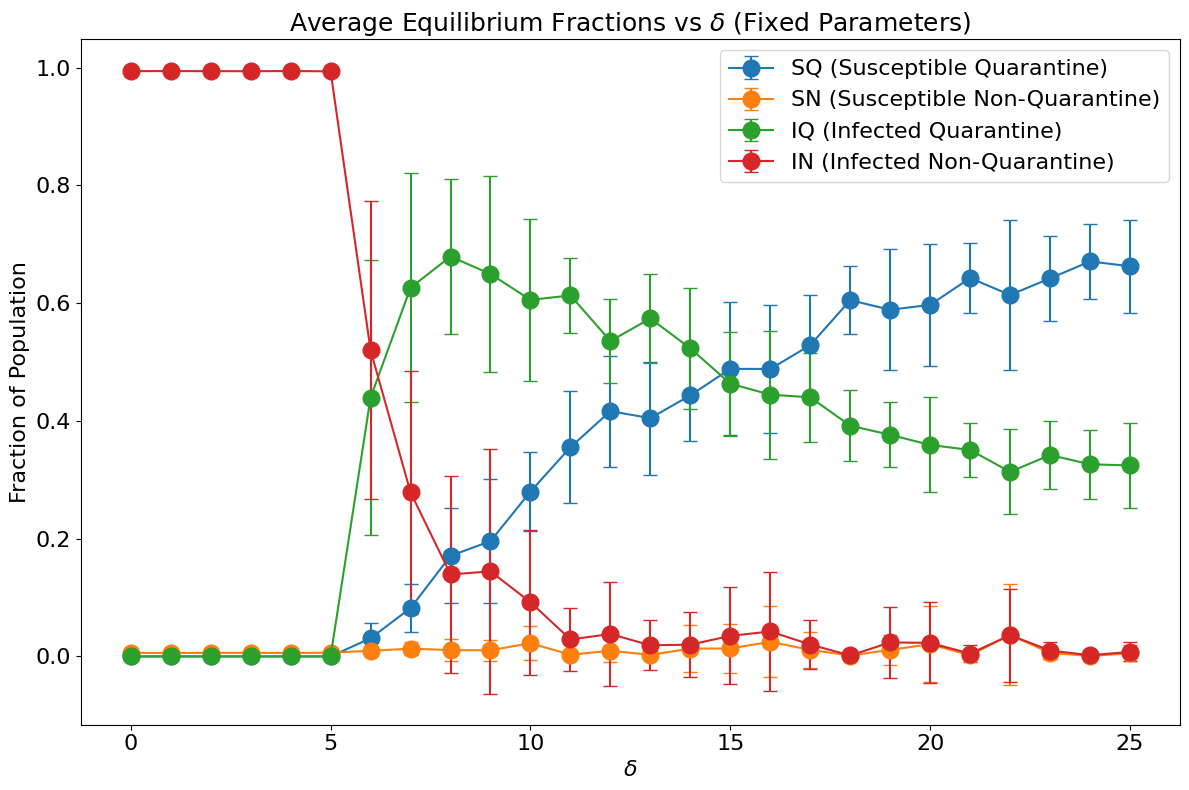

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# ------------------------------------------------------------------
# 1.  HELPERS
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
def generate_random_array(size):
    half_size = size // 2
    indices = np.random.choice(size, half_size, replace=False)
    array = np.zeros(size, dtype=int)
    array[indices] = 1
    np.random.shuffle(array)
    return array

def modify_array(arr):
    N = len(arr)
    num_twos = int(N * 0.005)
    num_threes = int(N * 0.005)

    zero_indices = np.where(arr == 0)[0]
    one_indices = np.where(arr == 1)[0]

    selected_zero_indices = np.random.choice(zero_indices, num_twos, replace=False)
    selected_one_indices = np.random.choice(one_indices, num_threes, replace=False)

    arr[selected_zero_indices] = 2
    arr[selected_one_indices] = 3

    return arr

def form_links(x, y):
    links = []
    for i in range(x):
        for k in range(y - 1):
            links.append([i * y + k, i * y + k + 1])
    for i in range(y):
        for k in range(x - 1):
            links.append([i + (k) * y, i + (k + 1) * y])
    for i in range(x):
        links.append([i * y, i * y + y - 1])
    for i in range(y):
        links.append([i, (x - 1) * y + i])
    return links

def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time, seed=None):
    """
    Runs a single simulation and returns the equilibrium fractions.

    Parameters:
    - k_lst: Initial state array
    - links: Network links
    - omega, delta, BN, BQ, BA, tau, rec, time: Simulation parameters
    - seed: Random seed for reproducibility

    Returns:
    - draw_log3: Fraction of Sq (Susceptible Quarantine)
    - draw_log4: Fraction of Sn (Susceptible Non-Quarantine)
    - draw_log5: Fraction of Iq (Infected Quarantine)
    - draw_log6: Fraction of In (Infected Non-Quarantine)
    """
    draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst.copy(), links,
                  omega=omega, delta=delta,
                  BN=BN, BQ=BQ, BA=BA,
                  tau=tau, rec=rec, time=time)   #, seed=seed (k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)

    return draw_log3, draw_log4, draw_log5, draw_log6
def runs_for_value(x, interval_specs, default_runs):
    """
    Decide how many Monte‑Carlo repetitions to use for a given parameter value.
    `interval_specs` is a list of (low, high, runs) – all inclusive.
    """
    for low, high, runs in interval_specs:
        if low <= x <= high:
            return runs
    return default_runs


def simulate_varying_parameter(k_lst, links, fixed_params,
                               varying_param_name, varying_param_list,
                               BQ, tau, time,
                               interval_specs, default_runs):
    """
    As before, but each parameter value may have its *own* run‑count.

    `interval_specs` : [(low, high, runs), …]  – inclusive bounds
    `default_runs`   : int                      – outside all intervals
    """
    # determine per‑value run counts
    run_counts = [runs_for_value(v, interval_specs, default_runs)
                  for v in varying_param_list]
    max_runs   = max(run_counts)

    n_params = len(varying_param_list)
    #  result containers filled with NaN so np.nanmean/np.nanstd work later
    SQ = np.full((n_params, max_runs), np.nan)
    SN = np.full_like(SQ, np.nan)
    IQ = np.full_like(SQ, np.nan)
    IN = np.full_like(SQ, np.nan)

    for i, (param_val, n_rep) in enumerate(zip(varying_param_list, run_counts)):
        print(f"δ = {param_val:5.2f}  →  {n_rep:2d} runs")
        for run in range(n_rep):
            cur = fixed_params.copy()
            cur[varying_param_name] = param_val
            omega = cur.get('omega')
            delta = cur.get('delta')
            BN    = cur.get('BN')
            rec   = cur.get('rec')
            BA    = (BN + BQ) / 2

            out = run_single_simulation(k_lst.copy(), links,
                                        omega, delta,
                                        BN, BQ, BA, tau, rec, time,
                                        seed=run+1)
            SQ[i, run], SN[i, run], IQ[i, run], IN[i, run] = \
                out[0][-1], out[1][-1], out[2][-1], out[3][-1]

    return SQ, SN, IQ, IN
# ------------------------------------------------------------------
# 2.  USER SETTINGS
# ------------------------------------------------------------------
# “boost” the number of runs for 15 ≤ δ ≤ 20
interval_specs = [(15, 20, 25)]   # low, high, runs
default_runs   = 10                # elsewhere

delta_list = np.arange(0, 25.01, 1)      # what you had
varying_param_name = 'delta'
fixed_params_delta = {'omega': 22.5, 'delta': None,
                      'BN': 0.41, 'rec': 0.04}

# ------------------------------------------------------------------
# 3.  RUN
# ------------------------------------------------------------------
k_lst  = modify_array(generate_random_array(10_000))
links  = form_links(100, 100)
BQ, tau, time = 0.01, 0.5, 500

SQ, SN, IQ, IN = simulate_varying_parameter(
    k_lst, links,
    fixed_params_delta,
    varying_param_name, delta_list,
    BQ, tau, time,
    interval_specs, default_runs
)

# 4.  stats & plot (nan‑aware)
avg_SQ, avg_SN = np.nanmean(SQ, 1), np.nanmean(SN, 1)
avg_IQ, avg_IN = np.nanmean(IQ, 1), np.nanmean(IN, 1)

std_SQ, std_SN = np.nanstd(SQ, 1), np.nanstd(SN, 1)
std_IQ, std_IN = np.nanstd(IQ, 1), np.nanstd(IN, 1)


def plot_varying_parameter(param_list, avg_SQ, avg_SN, avg_IQ, avg_IN,
                           std_SQ, std_SN, std_IQ, std_IN, varying_param_name, fixed_param_value):
    plt.figure(figsize=(12, 8))

    # Plot each equilibrium fraction with error bars
    plt.errorbar(param_list, avg_SQ, yerr=std_SQ,
                 label='SQ (Susceptible Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_SN, yerr=std_SN,
                 label='SN (Susceptible Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IQ, yerr=std_IQ,
                 label='IQ (Infected Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)
    plt.errorbar(param_list, avg_IN, yerr=std_IN,
                 label='IN (Infected Non-Quarantine)', fmt='-o', marker='o',
                 capsize=5, markersize=12)

    # Use Greek letter delta for the x-axis label if the varying parameter is 'delta'
    if varying_param_name.lower() == 'delta':
        xlabel = r'$\delta$'
    else:
        xlabel = varying_param_name.capitalize()

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel('Fraction of Population', fontsize=16)
    plt.title(rf'Average Equilibrium Fractions vs {xlabel} (Fixed Parameters)', fontsize=18)

    # Increase tick label sizes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    # Legend stays in the upper right corner with smaller font size
    plt.legend(loc='upper right', prop={'size': 16})

    plt.grid(False)
    plt.tight_layout()
    plt.show()
plot_varying_parameter(delta_list,
                       avg_SQ, avg_SN, avg_IQ, avg_IN,
                       std_SQ, std_SN, std_IQ, std_IN,
                       varying_param_name,
                       fixed_param_value=fixed_params_delta['omega'])


2025/6/22 Beta_A


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


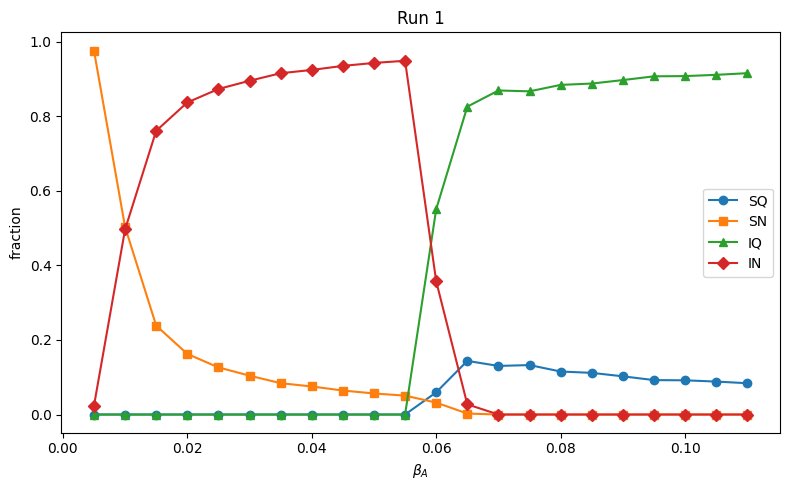

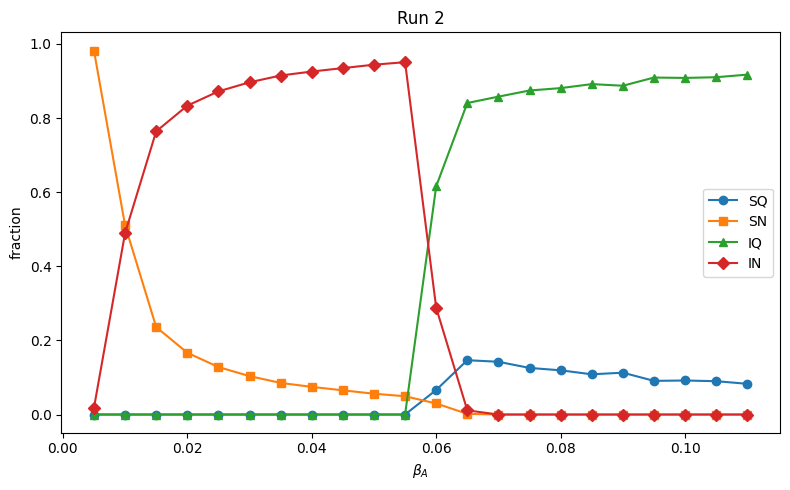

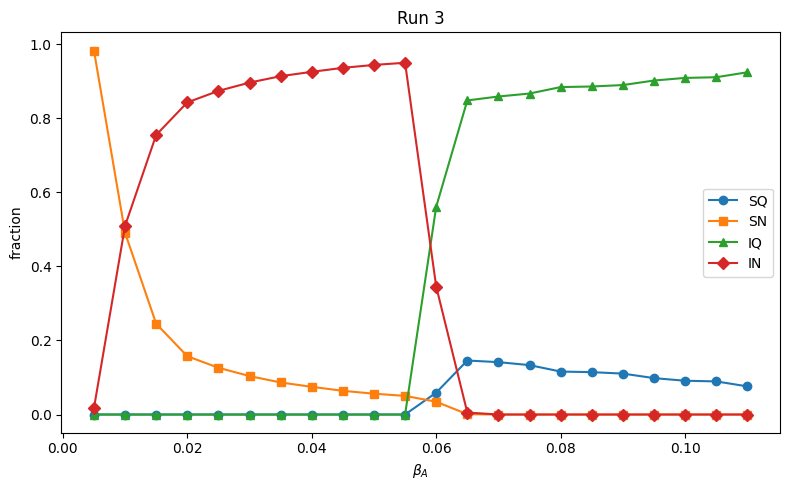

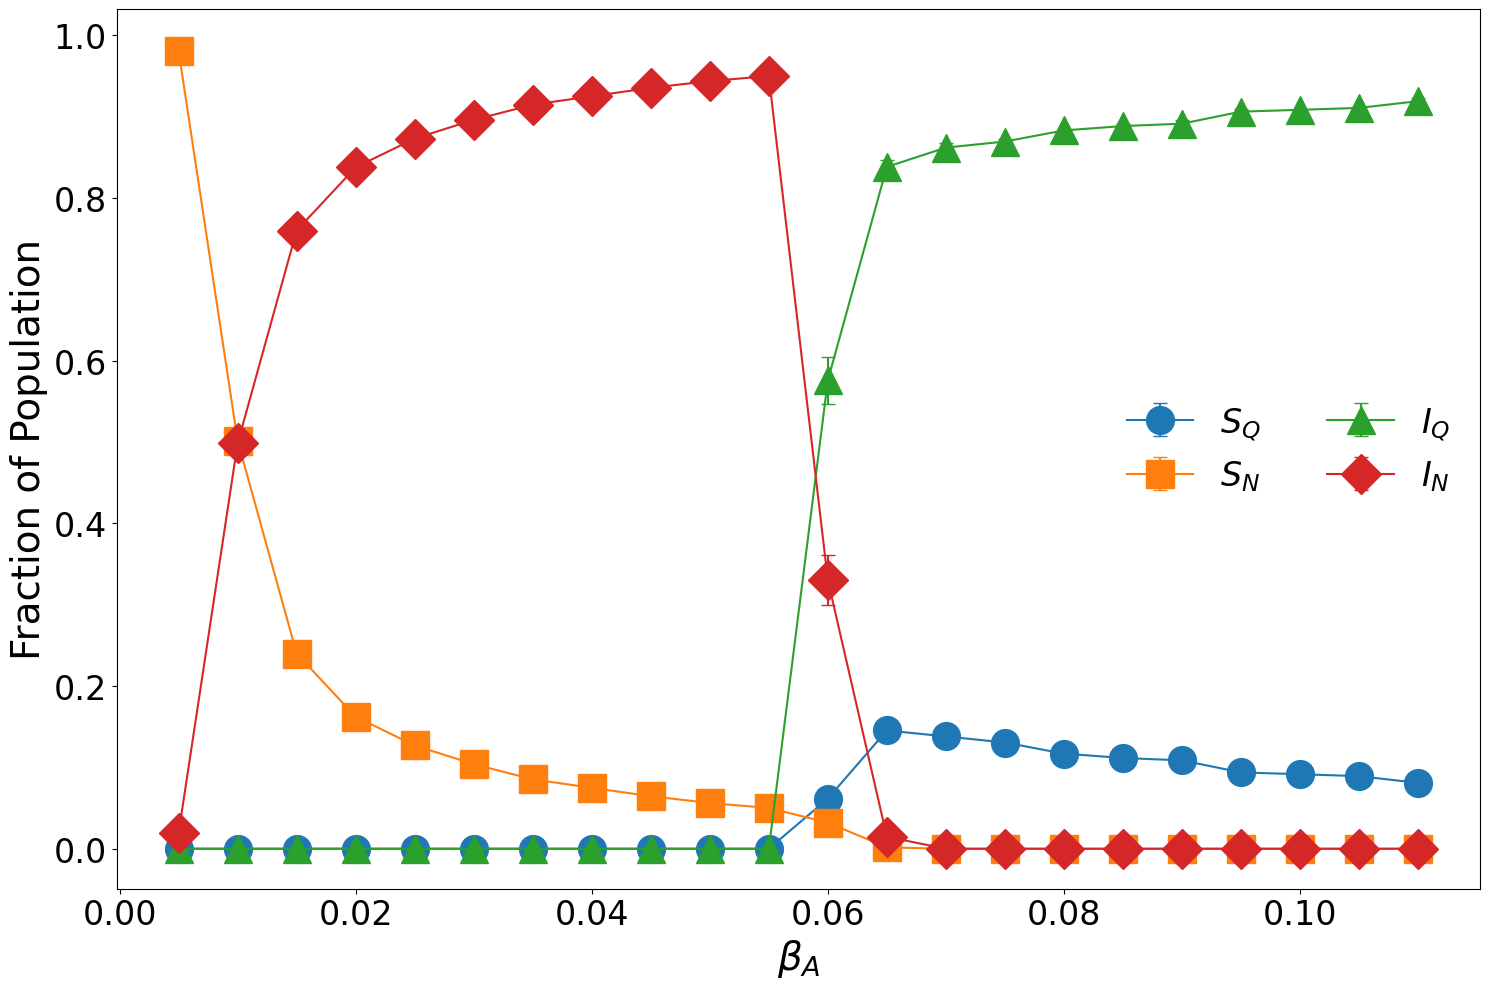

In [ ]:
# ================================================================
# 0.  IMPORTS & DRIVE (optional)
# ================================================================
import numpy as np, random, math, os, pandas as pd
import matplotlib.pyplot as plt
from decimal    import Decimal
from collections import Counter
from datetime   import datetime
from google.colab import drive
drive.mount('/content/drive')          # comment out if not needed

# ================================================================
# 1.  BASIC HELPERS
# ================================================================
def generate_random_array(size):
    """Half zeros, half ones, shuffled."""
    half_size = size // 2
    idx = np.random.choice(size, half_size, replace=False)
    arr = np.zeros(size, dtype=int)
    arr[idx] = 1
    np.random.shuffle(arr)
    return arr

def modify_array(arr):
    """Turn 0.5 % of 0→2 and 0.5 % of 1→3."""
    N = len(arr)
    n2 = int(N * 0.005)
    n3 = int(N * 0.005)
    zero_idx = np.where(arr == 0)[0]
    one_idx  = np.where(arr == 1)[0]
    arr[np.random.choice(zero_idx, n2, replace=False)] = 2
    arr[np.random.choice(one_idx,  n3, replace=False)] = 3
    return arr

def form_links(x, y):
    """4-neighbour lattice with periodic boundary conditions."""
    links = []
    for i in range(x):
        for k in range(y - 1):
            links.append([i * y + k, i * y + k + 1])
    for i in range(y):
        for k in range(x - 1):
            links.append([i + k * y, i + (k + 1) * y])
    for i in range(x):
        links.append([i * y, i * y + y - 1])
    for i in range(y):
        links.append([i, (x - 1) * y + i])
    return links

# ================================================================
# 2.  CORE DYNAMICS – unchanged from your script
# ================================================================
def simulate_dynamics(k_lst, links, omega, delta,
                      BN, BQ, BA, tau, rec, time):
    # --- counters to store time series
    draw_log  = []; draw_log2 = []
    draw_log3 = []; draw_log4 = []
    draw_log5 = []; draw_log6 = []

    old_klst = k_lst.copy()

    for r in range(1, time + 1):

        # --- behavioural flip ------------------------------------------------
        piQ = -omega
        piN = -Decimal(delta * BN * 10 * np.count_nonzero(
                       (old_klst == 2) | (old_klst == 3)) / len(old_klst))
        theta = np.where((k_lst == 0) | (k_lst == 2),
                         1/(1+np.exp((-float(piN)+piQ)/0.1)),
                         1/(1+np.exp((float(piN)-piQ)/0.1)))
        theta = (theta * tau * 1000).astype(int)
        rand  = np.random.randint(1, 1001, size=len(k_lst))
        temp  = k_lst.copy()
        k_lst[(temp == 0) & (theta >= rand)] = 1
        k_lst[(temp == 1) & (theta >= rand)] = 0
        k_lst[(temp == 2) & (theta >= rand)] = 3
        k_lst[(temp == 3) & (theta >= rand)] = 2

        # --- recovery --------------------------------------------------------
        if r > 2:
            rec_mask = (old_klst == 2) | (old_klst == 3)
            rec_rand = np.random.randint(1, 101, size=len(rec_mask))
            k_lst[rec_mask & (rec_rand <= rec*100)] = \
                np.where(old_klst[rec_mask & (rec_rand <= rec*100)] == 2, 0, 1)

        old_klst = k_lst.copy()

        # --- infections over links ------------------------------------------
        tmp = k_lst.copy()
        for a, b in links:
            if tmp[a] == 0 or tmp[b] == 0:
                if tmp[a] == 2 or tmp[b] == 2:   p = BQ
                elif tmp[a] == 3 or tmp[b] == 3: p = BA
                else:                            p = 0
                if np.random.rand() < p:
                    if tmp[a] == 0: k_lst[a] = 2
                    if tmp[b] == 0: k_lst[b] = 2
            elif tmp[a] == 1 or tmp[b] == 1:
                if tmp[a] == 2 or tmp[b] == 2:   p = BA
                elif tmp[a] == 3 or tmp[b] == 3: p = BN
                else:                            p = 0
                if np.random.rand() < p:
                    if tmp[a] == 1: k_lst[a] = 3
                    if tmp[b] == 1: k_lst[b] = 3

        # --- logs ------------------------------------------------------------
        draw_log.append(np.mean((k_lst == 2) | (k_lst == 3)))
        draw_log2.append(np.mean((k_lst == 1) | (k_lst == 3)))
        draw_log3.append(np.mean(k_lst == 0))
        draw_log4.append(np.mean(k_lst == 1))
        draw_log5.append(np.mean(k_lst == 2))
        draw_log6.append(np.mean(k_lst == 3))

    return draw_log, draw_log2, draw_log3, draw_log4, draw_log5, draw_log6

# wrapper: single equilibrium run ----------------------------------
def run_single_simulation(k_lst, links, omega, delta,
                          BN, BQ, BA, tau, rec, time):
    _, _, SQ, SN, IQ, IN = simulate_dynamics(
        k_lst.copy(), links, omega, delta, BN, BQ, BA, tau, rec, time)
    return SQ, SN, IQ, IN

# ================================================================
# 3.  SWEEP β_A (new)
# ================================================================
def simulate_single_parameter_BA(k_lst, links,
                                 omega, delta, tau, rec, time,
                                 BA_vals, num_runs,
                                 interval=None, interval_runs=None):
    nV = len(BA_vals)
    SQ = np.zeros((nV, num_runs))
    SN = np.zeros_like(SQ)
    IQ = np.zeros_like(SQ)
    IN = np.zeros_like(SQ)

    for run in range(num_runs):
        for i, BA in enumerate(BA_vals):
            BN = round(BA * 1.5, 3)
            BQ = round(BA * 0.5, 3)
            reps = interval_runs if interval and interval[0] <= BA <= interval[1] else 1
            vals = [run_single_simulation(k_lst, links,
                                          omega, delta, BN, BQ, BA,
                                          tau, rec, time)
                    for _ in range(reps)]
            SQ[i, run] = np.mean([v[0][-1] for v in vals])
            SN[i, run] = np.mean([v[1][-1] for v in vals])
            IQ[i, run] = np.mean([v[2][-1] for v in vals])
            IN[i, run] = np.mean([v[3][-1] for v in vals])

        # quick per-run visual
        plt.figure(figsize=(8, 5))
        plt.plot(BA_vals, SQ[:, run], 'o-', label='SQ')
        plt.plot(BA_vals, SN[:, run], 's-', label='SN')
        plt.plot(BA_vals, IQ[:, run], '^-', label='IQ')
        plt.plot(BA_vals, IN[:, run], 'D-', label='IN')
        plt.xlabel(r'$\beta_A$');  plt.ylabel('fraction');  plt.title(f'Run {run+1}')
        plt.legend();  plt.tight_layout();  plt.show()

    return SQ, SN, IQ, IN

# ================================================================
# 4.  RUN EXPERIMENT
# ================================================================
# lattice & initial state
size  = 10_000
k0    = modify_array(generate_random_array(size))
links = form_links(100, 100)

# parameters
delta, omega, tau, rec, time = 25, 20, 1, 0.02, 500
BA_vals        = np.round(np.arange(0.005, 0.115, 0.005), 3)
num_runs       = 3
interval       = (0.025, 0.055)   # denser sampling window
interval_runs  = 8

# run
SQ, SN, IQ, IN = simulate_single_parameter_BA(
    k0, links, omega, delta, tau, rec, time,
    BA_vals, num_runs, interval, interval_runs)

# ================================================================
# 5.  AGGREGATE PLOT
# ================================================================
avg_SQ, std_SQ = SQ.mean(1), SQ.std(1)
avg_SN, std_SN = SN.mean(1), SN.std(1)
avg_IQ, std_IQ = IQ.mean(1), IQ.std(1)
avg_IN, std_IN = IN.mean(1), IN.std(1)

plt.figure(figsize=(15, 10))
plt.errorbar(BA_vals, avg_SQ, yerr=std_SQ, fmt='-o', markersize=20, capsize=5, label=r'$S_Q$')
plt.errorbar(BA_vals, avg_SN, yerr=std_SN, fmt='-s', markersize=20, capsize=5, label=r'$S_N$')
plt.errorbar(BA_vals, avg_IQ, yerr=std_IQ, fmt='-^', markersize=20, capsize=5, label=r'$I_Q$')
plt.errorbar(BA_vals, avg_IN, yerr=std_IN, fmt='-D', markersize=20, capsize=5, label=r'$I_N$')
plt.xlabel(r'$\beta_A$', fontsize=28);  plt.ylabel('Fraction of Population', fontsize=28)
plt.xticks(fontsize=24);  plt.yticks(fontsize=24)
plt.legend(ncol=2, frameon=False, prop={'size': 24});  plt.tight_layout();  plt.show()


# Testings (before 12/8/2024)

Single Simulation Line Graph


Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Rea

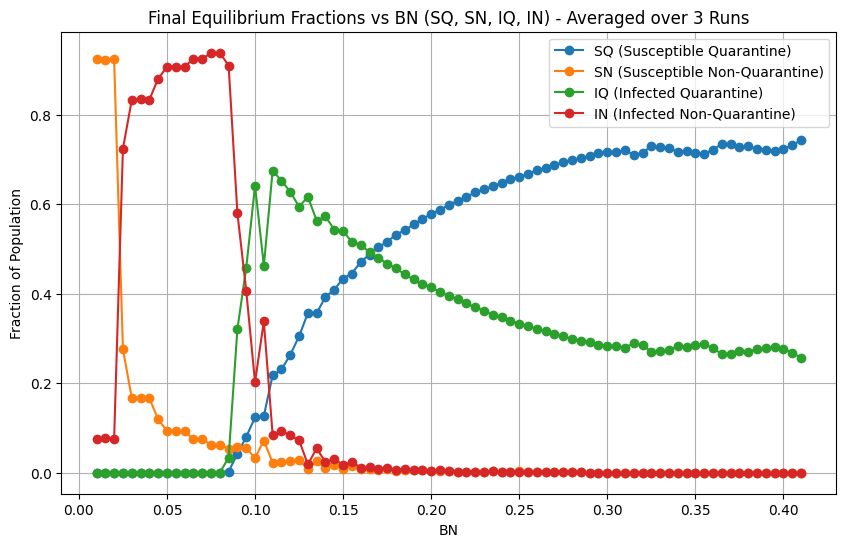

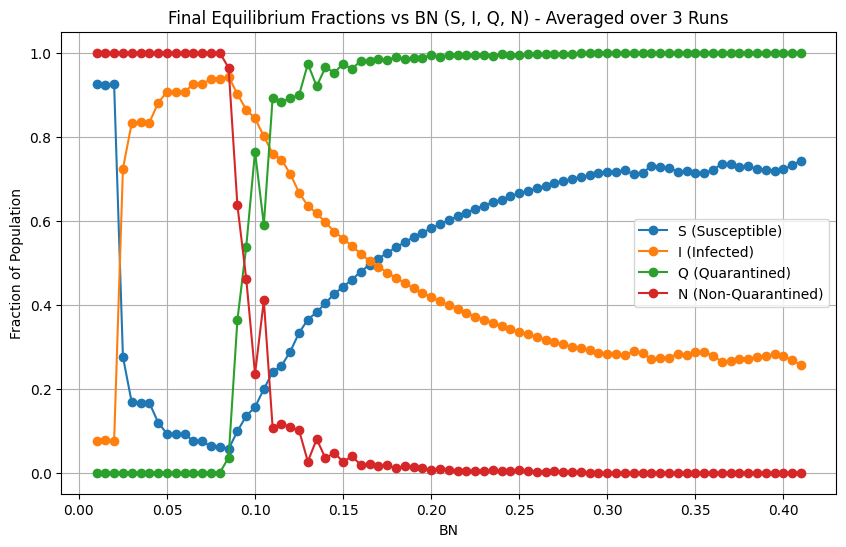

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to run the simulation
def simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst, num_runs):
    # Initialize arrays to store cumulative results
    cumulative_SQ = np.zeros(len(BN_lst))
    cumulative_SN = np.zeros(len(BN_lst))
    cumulative_IQ = np.zeros(len(BN_lst))
    cumulative_IN = np.zeros(len(BN_lst))

    # Run the simulation num_runs times and accumulate the results
    for _ in range(num_runs):
        final_SQ = []
        final_SN = []
        final_IQ = []
        final_IN = []

        for BN in BN_lst:
            BA = (BN + BQ) / 2  # Keep BA tied to BN and BQ
            draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)

            # Take the last value in each log as the equilibrium state
            final_SQ.append(draw_log3[-1])
            final_SN.append(draw_log4[-1])
            final_IQ.append(draw_log5[-1])
            final_IN.append(draw_log6[-1])

        # Accumulate the results
        cumulative_SQ += np.array(final_SQ)
        cumulative_SN += np.array(final_SN)
        cumulative_IQ += np.array(final_IQ)
        cumulative_IN += np.array(final_IN)

    # Take the average over all runs
    avg_SQ = cumulative_SQ / num_runs
    avg_SN = cumulative_SN / num_runs
    avg_IQ = cumulative_IQ / num_runs
    avg_IN = cumulative_IN / num_runs

    return avg_SQ, avg_SN, avg_IQ, avg_IN

# Simulate dynamics for a single BN value
def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time):
    _, _, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
    return draw_log3, draw_log4, draw_log5, draw_log6

# Set up the parameter ranges and other constants
BN_lst = np.arange(0.01, 0.411, 0.005)  # Vary BN from 0.01 to 0.41
rec = 0.02
delta = 25
omega = 20
BQ = 0.01
tau = 0.5
time = 500
size = 90000
num_runs = 3  # Number of simulation runs to average

# Initialize agents and links
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(300, 300)

# Run the simulation with varying BN_lst and averaging over num_runs runs
avg_SQ, avg_SN, avg_IQ, avg_IN = simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst, num_runs)

# Plot the first graph (SQ, SN, IQ, IN)
plt.figure(figsize=(10, 6))
plt.plot(BN_lst, avg_SQ, label='SQ (Susceptible Quarantine)', marker='o')
plt.plot(BN_lst, avg_SN, label='SN (Susceptible Non-Quarantine)', marker='o')
plt.plot(BN_lst, avg_IQ, label='IQ (Infected Quarantine)', marker='o')
plt.plot(BN_lst, avg_IN, label='IN (Infected Non-Quarantine)', marker='o')

plt.xlabel('BN')
plt.ylabel('Fraction of Population')
plt.title(f'Final Equilibrium Fractions vs BN (SQ, SN, IQ, IN) - Averaged over {num_runs} Runs')
plt.legend()
plt.grid(True)
plt.show()

# Calculate S, I, Q, N groups
avg_S = avg_SQ + avg_SN  # S = SQ + SN
avg_I = avg_IQ + avg_IN  # I = IQ + IN
avg_Q = avg_SQ + avg_IQ  # Q = SQ + IQ
avg_N = avg_SN + avg_IN  # N = SN + IN

# Plot the second graph (S, I, Q, N)
plt.figure(figsize=(10, 6))
plt.plot(BN_lst, avg_S, label='S (Susceptible)', marker='o')
plt.plot(BN_lst, avg_I, label='I (Infected)', marker='o')
plt.plot(BN_lst, avg_Q, label='Q (Quarantined)', marker='o')
plt.plot(BN_lst, avg_N, label='N (Non-Quarantined)', marker='o')

plt.xlabel('BN')
plt.ylabel('Fraction of Population')
plt.title(f'Final Equilibrium Fractions vs BN (S, I, Q, N) - Averaged over {num_runs} Runs')
plt.legend()
plt.grid(True)
plt.show()


Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached
Equil. Reached


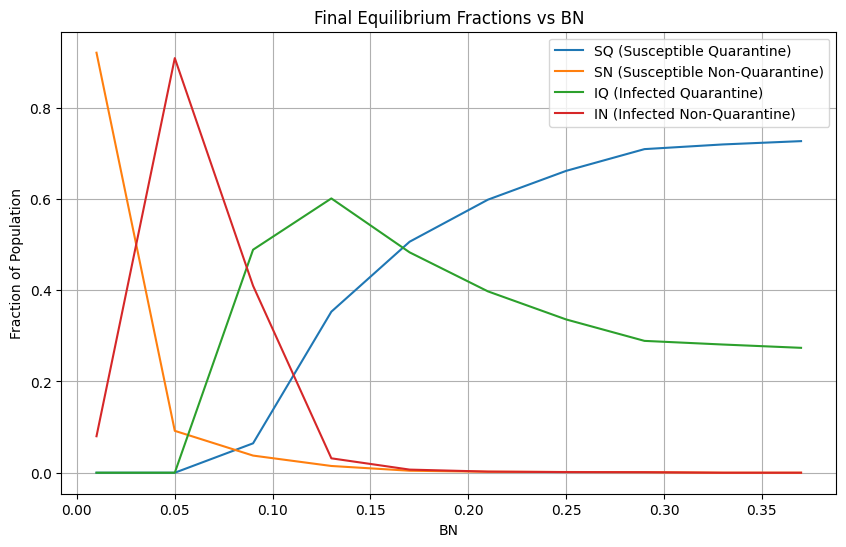

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to run the simulation
def simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst):
    final_SQ = []
    final_SN = []
    final_IQ = []
    final_IN = []

    for BN in BN_lst:
        BA = (BN + BQ) / 2  # Keep BA tied to BN and BQ
        draw_log3, draw_log4, draw_log5, draw_log6 = run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)

        # Take the last value in each log as the equilibrium state
        final_SQ.append(draw_log3[-1])
        final_SN.append(draw_log4[-1])
        final_IQ.append(draw_log5[-1])
        final_IN.append(draw_log6[-1])

    return final_SQ, final_SN, final_IQ, final_IN

# Simulate dynamics for a single BN value
def run_single_simulation(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time):
    _, _, draw_log3, draw_log4, draw_log5, draw_log6 = simulate_dynamics(k_lst, links, omega, delta, BN, BQ, BA, tau, rec, time)
    return draw_log3, draw_log4, draw_log5, draw_log6

# Set up the parameter ranges and other constants
BN_lst = np.arange(0.01, 0.41, 0.04)  # Vary BN from 0.01 to 0.41
rec = 0.02
delta = 25
omega = 20
BQ = 0.01
tau = 0.5
time = 500
size = 40000

# Initialize agents and links
k_lst = generate_random_array(size)
k_lst = modify_array(k_lst)
links = form_links(200, 200)

# Run the simulation with varying BN_lst
final_SQ, final_SN, final_IQ, final_IN = simulate_single_parameter(k_lst, links, omega, delta, BQ, tau, rec, time, BN_lst)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(BN_lst, final_SQ, label='SQ (Susceptible Quarantine)')
plt.plot(BN_lst, final_SN, label='SN (Susceptible Non-Quarantine)')
plt.plot(BN_lst, final_IQ, label='IQ (Infected Quarantine)')
plt.plot(BN_lst, final_IN, label='IN (Infected Non-Quarantine)')

plt.xlabel('BN')
plt.ylabel('Fraction of Population')
plt.title('Final Equilibrium Fractions vs BN')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def discrete_matshow(data):
    #plt.savefig('my_plot.png')
    plt.rcParams["figure.figsize"] = [8,8]

    # plt.axis('off')
    #plt.grid(axis='y')
    #plt.show()

    # get discrete colormap
    ccmap = plt.cm.get_cmap('tab20', 15)#.reversed()#np.max(data) - np.min(data) + 1#np.max(data)*2

    # set limits .5 outside true range
    mat = plt.imshow(data, cmap = ccmap.reversed(), vmin=1-0.5,#vmin=np.min(data) - 0
                      vmax=15+0.5)#0.5 vmax=np.max(data) + 0

    # tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(1,16))#np.min(data), np.max(data) + 1

    #cb = plt.colorbar()


    plt.gca().xaxis.tick_bottom() #<-------------Took hrs!!
    plt.gca().invert_yaxis() #<---------drawing-> top to bottom/ data generated -> BN from low to high (0.01-0.71) ====> has to invert

    #plt.imshow(data, interpolation="none")

    plt.xlabel("rec")
    plt.ylabel("omega")


    cax.remove()
    plt.axis('off')
    plt.plot()
    #plt.show() #<-------!!!!!!!!have to turn this off when graphing combined plot
    return plt

data_lst = []

#---------Color map plot-----------------------
reslt_lst = []

for i in range(0,11):#(1,7)
  t_lst = []
  for j in range(0,11):                              #6*6
    t_lst.append(lst[j+11*i]+1) #-----turn lst [1,5,7,15...] into [[1,5,7...],[15,1,6...]...]  drawing format
  reslt_lst.append(t_lst)

print(reslt_lst)


discrete_matshow(reslt_lst)
data_lst.append(reslt_lst)


#print(reslt_lst)
print(data_lst,len(data_lst))


plt.rcParams["figure.figsize"] = [12,8]#12,8/15,15
for i in range(len(data_lst)):
  plt.subplot(11,11,i+1)
#plt.plot(x, y_sin, 'bo-')
  discrete_matshow(data_lst[i])


plt.subplots_adjust(wspace=0, hspace=0)


plt.show()
